In [3]:
import nb_utils
import os
import pickle
import torch
import nb_utils
from lightning_data_modules import HaarDecomposedDataset, ImageDatasets, PairedDataset, SyntheticDataset, SyntheticPairedDataset, Synthetic1DConditionalDataset, SyntheticTimeSeries, SRDataset, SRFLOWDataset, KSphereDataset, MammothDataset, LineDataset, GanDataset #needed for datamodule registration
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.KSphereGroundTruthModel import KSphereGroundTruthModel
from models.ksphere_gt import KSphereGT
from models.ddpm import DDPM
from models.fcn import FCN
import pickle
import sde_lib
from dim_reduction import get_manifold_dimension

In [4]:
config_path ='logs/ksphere/robustness/std=0.0/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
#config.model.checkpoint_path = $os.path.join(log_path, log_name, "checkpoints/best/last.ckpt")
config.model.checkpoint_path = 'logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt'

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
config.training.batch_size=32
config.dim_estimation.num_datapoints=5

In [9]:
import torch 
from pathlib import Path
import os
from lightning_modules.utils import create_lightning_module
from lightning_data_modules.utils import create_lightning_datamodule
from models import utils as mutils
import math
from tqdm import tqdm
import pickle

#---- create the setup ---
def robust(config, noise=0):
  log_path = config.logging.log_path
  log_name = config.logging.log_name
  save_path = os.path.join(log_path, log_name, 'svd')
  Path(save_path).mkdir(parents=True, exist_ok=True)

  DataModule = create_lightning_datamodule(config)
  DataModule.setup()
  train_dataloader = DataModule.train_dataloader()
    
  pl_module = create_lightning_module(config)
  pl_module = pl_module.load_from_checkpoint(config.model.checkpoint_path)
  pl_module.configure_sde(config)

  #get the ema parameters for evaluation
  #pl_module.ema.store(pl_module.parameters())
  #pl_module.ema.copy_to(pl_module.parameters()) 

  device = config.device
  pl_module = pl_module.to(device)
  pl_module.eval()
  
  score_model = pl_module.score_model
  sde = pl_module.sde
  score_fn = mutils.get_score_fn(sde, score_model, conditional=False, train=False, continuous=True)
  #---- end of setup ----

  num_datapoints = 100
  singular_values = []
  normalized_scores_list = []
  idx = 0
  with tqdm(total=num_datapoints) as pbar:
    for _, orig_batch in enumerate(train_dataloader):

      orig_batch = orig_batch.to(device)
      batchsize = orig_batch.size(0)
      
      if idx+1 >= num_datapoints:
          break
        
      for x in orig_batch:
        if idx+1 >= num_datapoints:
          break
        
        ambient_dim = math.prod(x.shape[1:])
        x = x.repeat([batchsize,]+[1 for i in range(len(x.shape))])

        num_batches = ambient_dim // batchsize + 1
        extra_in_last_batch = ambient_dim - (ambient_dim // batchsize) * batchsize
        num_batches *= 8

        t = pl_module.sampling_eps
        vec_t = torch.ones(x.size(0), device=device) * t

        scores = []
        for i in range(1, num_batches+1):
          batch = x.clone()

          mean, std = sde.marginal_prob(batch, vec_t)
          z = torch.randn_like(batch)
          batch = mean + std[(...,) + (None,) * len(batch.shape[1:])] * z
          score = score_fn(batch, vec_t).detach().cpu()

          if i < num_batches:
            scores.append(score)
          else:
            scores.append(score[:extra_in_last_batch])
        
        scores = torch.cat(scores, dim=0)
        scores = torch.flatten(scores, start_dim=1)

        means = scores.mean(dim=0, keepdim=True)
        normalized_scores = scores - means
        print(normalized_scores.shape)
        #corrupt
        norm = torch.linalg.norm(normalized_scores, dim=1).mean()
        corruption = noise * norm * torch.randn_like(normalized_scores) / np.sqrt(normalized_scores.shape[1])
        corruption_norm = torch.linalg.norm(corruption, dim=1).mean()
        print(f'score norm: {norm}, corruption norm: {corruption_norm}, corruption_std: {noise * norm / np.sqrt(normalized_scores.shape[1])}')
        normalized_scores = corruption + normalized_scores
        
        #normalized_scores_list.append(normalized_scores.tolist())

        u, s, v = torch.linalg.svd(normalized_scores)
        s = s.tolist()
        singular_values.append(s)

        idx+=1
        pbar.update(1)
    return singular_values

In [10]:
stds = np.linspace(0, 1, 20)
r = []
for std in stds:
    singular_values = robust(config, noise=std)
    r.append(singular_values)

Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 55.56it/s]

torch.Size([225, 100])
score norm: 77236.8984375, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77504.8515625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77407.796875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77254.21875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76970.265625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76824.625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76681.140625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77573.703125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76772.53125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77113.6015625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77651.3984375, corruption norm: 0.0, corruption_std: 0.0


 33%|███▎      | 33/100 [00:00<00:00, 85.39it/s]

torch.Size([225, 100])
score norm: 77013.8828125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77196.7578125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77919.6953125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77032.1953125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76948.171875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77693.5625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77727.828125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76610.1328125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77206.390625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76865.140625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77554.46875, corruption norm: 0.0, corruption_std: 0

 55%|█████▌    | 55/100 [00:00<00:00, 95.64it/s]

torch.Size([225, 100])
score norm: 77250.078125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76920.859375, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 78042.6171875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77718.453125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77722.8828125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77501.078125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77407.2265625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77248.3125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 78287.15625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77321.7578125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 78061.7265625, corruption norm: 0.0, corruption_std: 0

 77%|███████▋  | 77/100 [00:00<00:00, 99.80it/s]

torch.Size([225, 100])
score norm: 76833.53125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77479.8984375, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77073.609375, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76329.171875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77869.4765625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 78380.328125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76861.53125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77538.640625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 78125.9375, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76804.625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77006.0859375, corruption norm: 0.0, corruption_std: 0.0
tor

 99%|█████████▉| 99/100 [00:01<00:00, 88.14it/s] 

torch.Size([225, 100])
score norm: 77220.671875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77368.296875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77839.296875, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77624.25, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77138.859375, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 76776.828125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77451.265625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77952.3359375, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77489.3125, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77162.015625, corruption norm: 0.0, corruption_std: 0.0
torch.Size([225, 100])
score norm: 77616.8828125, corruption norm: 0.0, corruption_std: 0.0
tor


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 51.89it/s]

torch.Size([225, 100])
score norm: 77553.0078125, corruption norm: 4085.4677734375, corruption_std: 408.1737365722656
torch.Size([225, 100])
score norm: 77272.25, corruption norm: 4050.80419921875, corruption_std: 406.696044921875
torch.Size([225, 100])
score norm: 77869.625, corruption norm: 4093.942138671875, corruption_std: 409.84014892578125
torch.Size([225, 100])
score norm: 77478.1171875, corruption norm: 4035.2314453125, corruption_std: 407.7795715332031
torch.Size([225, 100])
score norm: 77165.6171875, corruption norm: 4048.470458984375, corruption_std: 406.13482666015625
torch.Size([225, 100])
score norm: 77388.890625, corruption norm: 4073.6533203125, corruption_std: 407.3099670410156
torch.Size([225, 100])
score norm: 77061.4375, corruption norm: 4079.058837890625, corruption_std: 405.5865173339844
torch.Size([225, 100])
score norm: 77735.0859375, corruption norm: 4108.52783203125, corruption_std: 409.13201904296875
torch.Size([225, 100])
score norm: 77507.9296875, corruptio

 30%|███       | 30/100 [00:00<00:00, 78.78it/s]

torch.Size([225, 100])
score norm: 77148.9296875, corruption norm: 4063.405517578125, corruption_std: 406.0469970703125
torch.Size([225, 100])
score norm: 76925.46875, corruption norm: 4085.322509765625, corruption_std: 404.87091064453125
torch.Size([225, 100])
score norm: 77570.0234375, corruption norm: 4086.921630859375, corruption_std: 408.2632751464844
torch.Size([225, 100])
score norm: 76919.4375, corruption norm: 4036.92333984375, corruption_std: 404.8391418457031
torch.Size([225, 100])
score norm: 77365.3671875, corruption norm: 4081.86376953125, corruption_std: 407.1861572265625
torch.Size([225, 100])
score norm: 77495.3984375, corruption norm: 4047.945068359375, corruption_std: 407.87054443359375
torch.Size([225, 100])
score norm: 77785.1171875, corruption norm: 4096.4697265625, corruption_std: 409.3953552246094
torch.Size([225, 100])
score norm: 77147.46875, corruption norm: 4065.735595703125, corruption_std: 406.039306640625
torch.Size([225, 100])
score norm: 77153.3125, cor

 50%|█████     | 50/100 [00:00<00:00, 88.80it/s]

torch.Size([225, 100])
score norm: 77528.5234375, corruption norm: 4063.6728515625, corruption_std: 408.04486083984375
torch.Size([225, 100])
score norm: 76588.671875, corruption norm: 4019.489990234375, corruption_std: 403.0982666015625
torch.Size([225, 100])
score norm: 77326.7265625, corruption norm: 4077.17529296875, corruption_std: 406.9827575683594
torch.Size([225, 100])
score norm: 77593.3125, corruption norm: 4067.70166015625, corruption_std: 408.3858642578125
torch.Size([225, 100])
score norm: 76574.734375, corruption norm: 4043.575927734375, corruption_std: 403.0249328613281
torch.Size([225, 100])
score norm: 77782.9140625, corruption norm: 4087.480712890625, corruption_std: 409.3837585449219
torch.Size([225, 100])
score norm: 77628.65625, corruption norm: 4073.094482421875, corruption_std: 408.5718688964844
torch.Size([225, 100])
score norm: 77683.8828125, corruption norm: 4076.452392578125, corruption_std: 408.862548828125
torch.Size([225, 100])
score norm: 77090.71875, cor

 72%|███████▏  | 72/100 [00:00<00:00, 96.97it/s]

torch.Size([225, 100])
score norm: 77938.8515625, corruption norm: 4074.331787109375, corruption_std: 410.2044982910156
torch.Size([225, 100])
score norm: 77994.2578125, corruption norm: 4129.65966796875, corruption_std: 410.49609375
torch.Size([225, 100])
score norm: 78235.71875, corruption norm: 4103.07763671875, corruption_std: 411.7669372558594
torch.Size([225, 100])
score norm: 77577.5546875, corruption norm: 4091.09619140625, corruption_std: 408.30291748046875
torch.Size([225, 100])
score norm: 77014.2734375, corruption norm: 4051.96044921875, corruption_std: 405.3382873535156
torch.Size([225, 100])
score norm: 76815.5, corruption norm: 4034.5244140625, corruption_std: 404.2921142578125
torch.Size([225, 100])
score norm: 77296.0078125, corruption norm: 4039.538330078125, corruption_std: 406.82110595703125
torch.Size([225, 100])
score norm: 77105.6796875, corruption norm: 4058.007568359375, corruption_std: 405.8193664550781
torch.Size([225, 100])
score norm: 77778.328125, corrupti

 94%|█████████▍| 94/100 [00:01<00:00, 100.72it/s]

score norm: 77330.1171875, corruption norm: 4071.367431640625, corruption_std: 407.0006103515625
torch.Size([225, 100])
score norm: 77416.796875, corruption norm: 4058.46435546875, corruption_std: 407.45684814453125
torch.Size([225, 100])
score norm: 77217.015625, corruption norm: 4057.1123046875, corruption_std: 406.40533447265625
torch.Size([225, 100])
score norm: 77983.140625, corruption norm: 4106.15966796875, corruption_std: 410.4375915527344
torch.Size([225, 100])
score norm: 77287.2265625, corruption norm: 4010.6796875, corruption_std: 406.7748718261719
torch.Size([225, 100])
score norm: 77164.7265625, corruption norm: 4030.431884765625, corruption_std: 406.1301574707031
torch.Size([225, 100])
score norm: 78057.4140625, corruption norm: 4075.058349609375, corruption_std: 410.8285217285156
torch.Size([225, 100])
score norm: 76727.03125, corruption norm: 4059.784423828125, corruption_std: 403.82647705078125
torch.Size([225, 100])
score norm: 76654.6171875, corruption norm: 4015.95

 99%|█████████▉| 99/100 [00:01<00:00, 83.88it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 52.41it/s]

torch.Size([225, 100])
score norm: 77523.8828125, corruption norm: 8226.9853515625, corruption_std: 816.0408935546875
torch.Size([225, 100])
score norm: 77350.90625, corruption norm: 8162.3720703125, corruption_std: 814.2200927734375
torch.Size([225, 100])
score norm: 76923.421875, corruption norm: 8072.23828125, corruption_std: 809.72021484375
torch.Size([225, 100])
score norm: 77748.9140625, corruption norm: 8209.52734375, corruption_std: 818.4096069335938
torch.Size([225, 100])
score norm: 77462.2109375, corruption norm: 8090.3046875, corruption_std: 815.3917236328125
torch.Size([225, 100])
score norm: 77070.3125, corruption norm: 8084.791015625, corruption_std: 811.2664794921875
torch.Size([225, 100])
score norm: 77163.59375, corruption norm: 8073.18896484375, corruption_std: 812.2483520507812
torch.Size([225, 100])
score norm: 78078.21875, corruption norm: 8178.2177734375, corruption_std: 821.8759765625
torch.Size([225, 100])
score norm: 77437.1796875, corruption norm: 8097.442382

 30%|███       | 30/100 [00:00<00:00, 81.01it/s]

torch.Size([225, 100])
score norm: 77658.1484375, corruption norm: 8147.81103515625, corruption_std: 817.4542236328125
torch.Size([225, 100])
score norm: 77689.03125, corruption norm: 8168.974609375, corruption_std: 817.779296875
torch.Size([225, 100])
score norm: 76734.3828125, corruption norm: 7985.33837890625, corruption_std: 807.7303466796875
torch.Size([225, 100])
score norm: 77097.953125, corruption norm: 8108.99072265625, corruption_std: 811.5574340820312
torch.Size([225, 100])
score norm: 77111.2890625, corruption norm: 8069.9912109375, corruption_std: 811.6978149414062
torch.Size([225, 100])
score norm: 77069.28125, corruption norm: 8039.234375, corruption_std: 811.255615234375
torch.Size([225, 100])
score norm: 76734.0390625, corruption norm: 8019.140625, corruption_std: 807.7266845703125
torch.Size([225, 100])
score norm: 77512.5, corruption norm: 8082.90380859375, corruption_std: 815.9210205078125
torch.Size([225, 100])
score norm: 77395.5234375, corruption norm: 8111.74707

 52%|█████▏    | 52/100 [00:00<00:00, 93.78it/s]

torch.Size([225, 100])
score norm: 77017.3828125, corruption norm: 8134.2421875, corruption_std: 810.7092895507812
torch.Size([225, 100])
score norm: 77343.53125, corruption norm: 8066.39208984375, corruption_std: 814.1424560546875
torch.Size([225, 100])
score norm: 76752.8125, corruption norm: 8103.12890625, corruption_std: 807.9243774414062
torch.Size([225, 100])
score norm: 77217.640625, corruption norm: 8110.0244140625, corruption_std: 812.8172607421875
torch.Size([225, 100])
score norm: 77809.5625, corruption norm: 8134.2333984375, corruption_std: 819.0480346679688
torch.Size([225, 100])
score norm: 78229.6640625, corruption norm: 8290.05859375, corruption_std: 823.4700927734375
torch.Size([225, 100])
score norm: 77454.3984375, corruption norm: 8101.97119140625, corruption_std: 815.3094482421875
torch.Size([225, 100])
score norm: 77988.296875, corruption norm: 8183.5556640625, corruption_std: 820.9295043945312
torch.Size([225, 100])
score norm: 77759.0390625, corruption norm: 8109

 74%|███████▍  | 74/100 [00:00<00:00, 99.68it/s]

torch.Size([225, 100])
score norm: 77315.9453125, corruption norm: 8085.5234375, corruption_std: 813.85205078125
torch.Size([225, 100])
score norm: 76974.0390625, corruption norm: 8080.56201171875, corruption_std: 810.2530517578125
torch.Size([225, 100])
score norm: 77505.3046875, corruption norm: 8156.169921875, corruption_std: 815.8453369140625
torch.Size([225, 100])
score norm: 77071.265625, corruption norm: 8063.4228515625, corruption_std: 811.2764892578125
torch.Size([225, 100])
score norm: 77256.46875, corruption norm: 8111.578125, corruption_std: 813.2259521484375
torch.Size([225, 100])
score norm: 77717.2109375, corruption norm: 8126.6279296875, corruption_std: 818.075927734375
torch.Size([225, 100])
score norm: 77040.4609375, corruption norm: 8071.8740234375, corruption_std: 810.9522705078125
torch.Size([225, 100])
score norm: 76988.0078125, corruption norm: 8043.37353515625, corruption_std: 810.4000854492188
torch.Size([225, 100])
score norm: 76372.6171875, corruption norm: 8

 96%|█████████▌| 96/100 [00:01<00:00, 102.84it/s]

torch.Size([225, 100])
score norm: 77476.1171875, corruption norm: 8154.99560546875, corruption_std: 815.5380859375
torch.Size([225, 100])
score norm: 76239.1796875, corruption norm: 7922.45654296875, corruption_std: 802.5177001953125
torch.Size([225, 100])
score norm: 77479.34375, corruption norm: 8145.1357421875, corruption_std: 815.572021484375
torch.Size([225, 100])
score norm: 76936.8984375, corruption norm: 8131.3681640625, corruption_std: 809.8621215820312
torch.Size([225, 100])
score norm: 77192.4140625, corruption norm: 8137.84619140625, corruption_std: 812.5516967773438
torch.Size([225, 100])
score norm: 77287.625, corruption norm: 8141.52099609375, corruption_std: 813.553955078125
torch.Size([225, 100])
score norm: 77303.328125, corruption norm: 8098.4599609375, corruption_std: 813.71923828125
torch.Size([225, 100])
score norm: 76613.703125, corruption norm: 8085.14404296875, corruption_std: 806.4600830078125
torch.Size([225, 100])
score norm: 77584.0078125, corruption norm:

 99%|█████████▉| 99/100 [00:01<00:00, 86.92it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 57.90it/s]

torch.Size([225, 100])
score norm: 77858.6171875, corruption norm: 12218.27734375, corruption_std: 1229.3465576171875
torch.Size([225, 100])
score norm: 77505.0703125, corruption norm: 12279.8740234375, corruption_std: 1223.7642822265625
torch.Size([225, 100])
score norm: 77128.265625, corruption norm: 12186.703125, corruption_std: 1217.814697265625
torch.Size([225, 100])
score norm: 77513.765625, corruption norm: 12083.9912109375, corruption_std: 1223.901611328125
torch.Size([225, 100])
score norm: 77253.1484375, corruption norm: 12197.412109375, corruption_std: 1219.7864990234375
torch.Size([225, 100])
score norm: 78358.640625, corruption norm: 12436.17578125, corruption_std: 1237.2415771484375
torch.Size([225, 100])
score norm: 77025.4140625, corruption norm: 12090.6728515625, corruption_std: 1216.190673828125
torch.Size([225, 100])
score norm: 78040.34375, corruption norm: 12308.0224609375, corruption_std: 1232.2159423828125
torch.Size([225, 100])
score norm: 78250.84375, corruptio

 33%|███▎      | 33/100 [00:00<00:00, 86.49it/s]

torch.Size([225, 100])
score norm: 77616.21875, corruption norm: 12123.9775390625, corruption_std: 1225.519287109375
torch.Size([225, 100])
score norm: 77698.984375, corruption norm: 12317.0478515625, corruption_std: 1226.825927734375
torch.Size([225, 100])
score norm: 77438.8125, corruption norm: 12169.3310546875, corruption_std: 1222.718017578125
torch.Size([225, 100])
score norm: 77020.234375, corruption norm: 12107.396484375, corruption_std: 1216.10888671875
torch.Size([225, 100])
score norm: 77340.9296875, corruption norm: 12327.2392578125, corruption_std: 1221.172607421875
torch.Size([225, 100])
score norm: 77603.8984375, corruption norm: 12215.8779296875, corruption_std: 1225.32470703125
torch.Size([225, 100])
score norm: 77669.046875, corruption norm: 12239.3115234375, corruption_std: 1226.353271484375
torch.Size([225, 100])
score norm: 77534.671875, corruption norm: 12185.685546875, corruption_std: 1224.231689453125
torch.Size([225, 100])
score norm: 76684.015625, corruption n

 54%|█████▍    | 54/100 [00:00<00:00, 93.32it/s]

torch.Size([225, 100])
score norm: 76852.828125, corruption norm: 12086.5126953125, corruption_std: 1213.465576171875
torch.Size([225, 100])
score norm: 76535.625, corruption norm: 12093.580078125, corruption_std: 1208.457275390625
torch.Size([225, 100])
score norm: 77997.65625, corruption norm: 12229.2841796875, corruption_std: 1231.5418701171875
torch.Size([225, 100])
score norm: 78082.1015625, corruption norm: 12293.982421875, corruption_std: 1232.875244140625
torch.Size([225, 100])
score norm: 77389.984375, corruption norm: 12264.83203125, corruption_std: 1221.947021484375
torch.Size([225, 100])
score norm: 77812.9765625, corruption norm: 12261.529296875, corruption_std: 1228.6258544921875
torch.Size([225, 100])
score norm: 77943.2421875, corruption norm: 12283.5654296875, corruption_std: 1230.6827392578125
torch.Size([225, 100])
score norm: 77002.9453125, corruption norm: 12052.771484375, corruption_std: 1215.8359375
torch.Size([225, 100])
score norm: 77095.5, corruption norm: 121

 75%|███████▌  | 75/100 [00:00<00:00, 95.81it/s]

torch.Size([225, 100])
score norm: 77716.6015625, corruption norm: 12274.5185546875, corruption_std: 1227.104248046875
torch.Size([225, 100])
score norm: 77694.4375, corruption norm: 12207.6318359375, corruption_std: 1226.754150390625
torch.Size([225, 100])
score norm: 77100.8125, corruption norm: 12185.1962890625, corruption_std: 1217.3812255859375
torch.Size([225, 100])
score norm: 77432.0, corruption norm: 12171.091796875, corruption_std: 1222.6104736328125
torch.Size([225, 100])
score norm: 77130.078125, corruption norm: 12188.5859375, corruption_std: 1217.84326171875
torch.Size([225, 100])
score norm: 77631.5390625, corruption norm: 12203.107421875, corruption_std: 1225.7611083984375
torch.Size([225, 100])
score norm: 77067.765625, corruption norm: 12109.3466796875, corruption_std: 1216.859375
torch.Size([225, 100])
score norm: 77469.796875, corruption norm: 12277.404296875, corruption_std: 1223.207275390625
torch.Size([225, 100])
score norm: 77559.0859375, corruption norm: 12329.

 97%|█████████▋| 97/100 [00:01<00:00, 99.15it/s]

torch.Size([225, 100])
score norm: 76996.765625, corruption norm: 12026.134765625, corruption_std: 1215.7384033203125
torch.Size([225, 100])
score norm: 77184.1796875, corruption norm: 12042.142578125, corruption_std: 1218.697509765625
torch.Size([225, 100])
score norm: 77155.53125, corruption norm: 12097.2451171875, corruption_std: 1218.2452392578125
torch.Size([225, 100])
score norm: 77591.2265625, corruption norm: 12304.3125, corruption_std: 1225.1246337890625
torch.Size([225, 100])
score norm: 77496.9765625, corruption norm: 12219.0322265625, corruption_std: 1223.636474609375
torch.Size([225, 100])
score norm: 77458.3359375, corruption norm: 12201.33203125, corruption_std: 1223.0262451171875
torch.Size([225, 100])
score norm: 77337.3671875, corruption norm: 12190.490234375, corruption_std: 1221.1163330078125
torch.Size([225, 100])
score norm: 76816.1953125, corruption norm: 12096.5556640625, corruption_std: 1212.88720703125
torch.Size([225, 100])
score norm: 77663.125, corruption n

 99%|█████████▉| 99/100 [00:01<00:00, 86.08it/s]
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 51.59it/s]

torch.Size([225, 100])
score norm: 77703.28125, corruption norm: 16324.5068359375, corruption_std: 1635.858642578125
torch.Size([225, 100])
score norm: 77217.21875, corruption norm: 16131.7685546875, corruption_std: 1625.625732421875
torch.Size([225, 100])
score norm: 77341.4921875, corruption norm: 16206.0830078125, corruption_std: 1628.241943359375
torch.Size([225, 100])
score norm: 77946.0, corruption norm: 16462.396484375, corruption_std: 1640.9683837890625
torch.Size([225, 100])
score norm: 77065.421875, corruption norm: 16081.53515625, corruption_std: 1622.429931640625
torch.Size([225, 100])
score norm: 78544.3984375, corruption norm: 16516.373046875, corruption_std: 1653.566162109375
torch.Size([225, 100])
score norm: 76743.859375, corruption norm: 16229.1943359375, corruption_std: 1615.6602783203125
torch.Size([225, 100])
score norm: 77099.9609375, corruption norm: 16186.1640625, corruption_std: 1623.1571044921875
torch.Size([225, 100])
score norm: 77612.34375, corruption norm:

 30%|███       | 30/100 [00:00<00:00, 78.71it/s]

torch.Size([225, 100])
score norm: 77606.8828125, corruption norm: 16295.412109375, corruption_std: 1633.8291015625
torch.Size([225, 100])
score norm: 77635.9296875, corruption norm: 16205.65625, corruption_std: 1634.440673828125
torch.Size([225, 100])
score norm: 77219.9921875, corruption norm: 16291.2099609375, corruption_std: 1625.68408203125
torch.Size([225, 100])
score norm: 77632.7109375, corruption norm: 16294.65234375, corruption_std: 1634.372802734375
torch.Size([225, 100])
score norm: 77244.125, corruption norm: 16259.978515625, corruption_std: 1626.192138671875
torch.Size([225, 100])
score norm: 78074.828125, corruption norm: 16462.4296875, corruption_std: 1643.6806640625
torch.Size([225, 100])
score norm: 76971.234375, corruption norm: 16085.259765625, corruption_std: 1620.447021484375
torch.Size([225, 100])
score norm: 77191.359375, corruption norm: 16263.53125, corruption_std: 1625.081298828125
torch.Size([225, 100])
score norm: 77745.0546875, corruption norm: 16283.42578

 51%|█████     | 51/100 [00:00<00:00, 90.82it/s]

torch.Size([225, 100])
score norm: 77859.4375, corruption norm: 16337.90234375, corruption_std: 1639.1461181640625
torch.Size([225, 100])
score norm: 77625.3125, corruption norm: 16246.46484375, corruption_std: 1634.217041015625
torch.Size([225, 100])
score norm: 77199.71875, corruption norm: 16211.095703125, corruption_std: 1625.2572021484375
torch.Size([225, 100])
score norm: 77245.7578125, corruption norm: 16270.0546875, corruption_std: 1626.2264404296875
torch.Size([225, 100])
score norm: 77290.15625, corruption norm: 16263.8251953125, corruption_std: 1627.1612548828125
torch.Size([225, 100])
score norm: 77972.921875, corruption norm: 16341.2802734375, corruption_std: 1641.53515625
torch.Size([225, 100])
score norm: 77110.0078125, corruption norm: 16204.1865234375, corruption_std: 1623.3685302734375
torch.Size([225, 100])
score norm: 77904.7109375, corruption norm: 16329.484375, corruption_std: 1640.0992431640625
torch.Size([225, 100])
score norm: 77716.4765625, corruption norm: 16

 73%|███████▎  | 73/100 [00:00<00:00, 98.55it/s]

torch.Size([225, 100])
score norm: 77165.109375, corruption norm: 16291.345703125, corruption_std: 1624.528564453125
torch.Size([225, 100])
score norm: 76805.8046875, corruption norm: 16025.4345703125, corruption_std: 1616.96435546875
torch.Size([225, 100])
score norm: 77641.8125, corruption norm: 16284.4892578125, corruption_std: 1634.564453125
torch.Size([225, 100])
score norm: 76797.046875, corruption norm: 16079.546875, corruption_std: 1616.780029296875
torch.Size([225, 100])
score norm: 77485.265625, corruption norm: 16284.8701171875, corruption_std: 1631.268798828125
torch.Size([225, 100])
score norm: 77606.203125, corruption norm: 16434.58203125, corruption_std: 1633.8148193359375
torch.Size([225, 100])
score norm: 76861.78125, corruption norm: 16112.443359375, corruption_std: 1618.142822265625
torch.Size([225, 100])
score norm: 77142.21875, corruption norm: 16272.0302734375, corruption_std: 1624.046630859375
torch.Size([225, 100])
score norm: 77177.9453125, corruption norm: 161

 95%|█████████▌| 95/100 [00:01<00:00, 101.65it/s]

torch.Size([225, 100])
score norm: 78458.984375, corruption norm: 16425.369140625, corruption_std: 1651.7681884765625
torch.Size([225, 100])
score norm: 77185.3125, corruption norm: 16141.0185546875, corruption_std: 1624.9539794921875
torch.Size([225, 100])
score norm: 77697.4609375, corruption norm: 16249.646484375, corruption_std: 1635.736083984375
torch.Size([225, 100])
score norm: 77573.671875, corruption norm: 16202.2109375, corruption_std: 1633.1300048828125
torch.Size([225, 100])
score norm: 77230.375, corruption norm: 16107.5458984375, corruption_std: 1625.902587890625
torch.Size([225, 100])
score norm: 77203.8046875, corruption norm: 16083.751953125, corruption_std: 1625.34326171875
torch.Size([225, 100])
score norm: 77669.6796875, corruption norm: 16299.3837890625, corruption_std: 1635.151123046875
torch.Size([225, 100])
score norm: 77567.1796875, corruption norm: 16386.05078125, corruption_std: 1632.9932861328125
torch.Size([225, 100])
score norm: 77259.703125, corruption no

 99%|█████████▉| 99/100 [00:01<00:00, 85.11it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 58.96it/s]

torch.Size([225, 100])
score norm: 76907.734375, corruption norm: 20429.025390625, corruption_std: 2023.887939453125
torch.Size([225, 100])
score norm: 76412.3046875, corruption norm: 20017.72265625, corruption_std: 2010.8502197265625
torch.Size([225, 100])
score norm: 77256.109375, corruption norm: 20379.07421875, corruption_std: 2033.0556640625
torch.Size([225, 100])
score norm: 77273.3125, corruption norm: 20443.529296875, corruption_std: 2033.5081787109375
torch.Size([225, 100])
score norm: 77124.7734375, corruption norm: 20306.857421875, corruption_std: 2029.599365234375
torch.Size([225, 100])
score norm: 77340.4921875, corruption norm: 20339.826171875, corruption_std: 2035.276123046875
torch.Size([225, 100])
score norm: 76550.4375, corruption norm: 19929.66015625, corruption_std: 2014.4853515625
torch.Size([225, 100])
score norm: 77154.1328125, corruption norm: 20196.275390625, corruption_std: 2030.3720703125
torch.Size([225, 100])
score norm: 77491.0703125, corruption norm: 2018

 33%|███▎      | 33/100 [00:00<00:00, 86.96it/s]

torch.Size([225, 100])
score norm: 76930.7890625, corruption norm: 20230.76171875, corruption_std: 2024.4945068359375
torch.Size([225, 100])
score norm: 77126.7578125, corruption norm: 20321.791015625, corruption_std: 2029.651611328125
torch.Size([225, 100])
score norm: 77204.75, corruption norm: 20262.626953125, corruption_std: 2031.7041015625
torch.Size([225, 100])
score norm: 77466.3671875, corruption norm: 20174.38671875, corruption_std: 2038.588623046875
torch.Size([225, 100])
score norm: 76949.171875, corruption norm: 20314.380859375, corruption_std: 2024.978271484375
torch.Size([225, 100])
score norm: 77810.984375, corruption norm: 20585.85546875, corruption_std: 2047.6575927734375
torch.Size([225, 100])
score norm: 77495.0390625, corruption norm: 20360.736328125, corruption_std: 2039.3431396484375
torch.Size([225, 100])
score norm: 77734.046875, corruption norm: 20414.015625, corruption_std: 2045.6328125
torch.Size([225, 100])
score norm: 77816.875, corruption norm: 20427.70312

 55%|█████▌    | 55/100 [00:00<00:00, 96.47it/s]

torch.Size([225, 100])
score norm: 77593.703125, corruption norm: 20361.693359375, corruption_std: 2041.939697265625
torch.Size([225, 100])
score norm: 77014.7578125, corruption norm: 20184.6015625, corruption_std: 2026.704345703125
torch.Size([225, 100])
score norm: 77697.4375, corruption norm: 20371.75390625, corruption_std: 2044.6695556640625
torch.Size([225, 100])
score norm: 77118.53125, corruption norm: 20288.806640625, corruption_std: 2029.4351806640625
torch.Size([225, 100])
score norm: 77617.8515625, corruption norm: 20427.02734375, corruption_std: 2042.5751953125
torch.Size([225, 100])
score norm: 77618.3125, corruption norm: 20539.55078125, corruption_std: 2042.5872802734375
torch.Size([225, 100])
score norm: 77526.5234375, corruption norm: 20186.447265625, corruption_std: 2040.171630859375
torch.Size([225, 100])
score norm: 77436.5390625, corruption norm: 20285.654296875, corruption_std: 2037.8037109375
torch.Size([225, 100])
score norm: 77063.140625, corruption norm: 20207

 77%|███████▋  | 77/100 [00:00<00:00, 100.67it/s]

torch.Size([225, 100])
score norm: 77493.890625, corruption norm: 20162.439453125, corruption_std: 2039.3128662109375
torch.Size([225, 100])
score norm: 77382.640625, corruption norm: 20208.408203125, corruption_std: 2036.3853759765625
torch.Size([225, 100])
score norm: 77619.6015625, corruption norm: 20383.064453125, corruption_std: 2042.62109375
torch.Size([225, 100])
score norm: 77422.2578125, corruption norm: 20225.08984375, corruption_std: 2037.427978515625
torch.Size([225, 100])
score norm: 76415.6640625, corruption norm: 20071.619140625, corruption_std: 2010.938720703125
torch.Size([225, 100])
score norm: 76439.953125, corruption norm: 20158.904296875, corruption_std: 2011.5777587890625
torch.Size([225, 100])
score norm: 77968.9140625, corruption norm: 20434.53125, corruption_std: 2051.813720703125
torch.Size([225, 100])
score norm: 76992.640625, corruption norm: 20289.994140625, corruption_std: 2026.122314453125
torch.Size([225, 100])
score norm: 76880.859375, corruption norm: 

 99%|█████████▉| 99/100 [00:01<00:00, 89.04it/s] 

torch.Size([225, 100])
score norm: 77244.7109375, corruption norm: 20219.3125, corruption_std: 2032.755615234375
torch.Size([225, 100])
score norm: 77624.8125, corruption norm: 20290.802734375, corruption_std: 2042.7581787109375
torch.Size([225, 100])
score norm: 77237.15625, corruption norm: 20234.119140625, corruption_std: 2032.556884765625
torch.Size([225, 100])
score norm: 77176.3046875, corruption norm: 20195.736328125, corruption_std: 2030.9554443359375
torch.Size([225, 100])
score norm: 77510.328125, corruption norm: 20266.6875, corruption_std: 2039.7454833984375
torch.Size([225, 100])
score norm: 76907.9375, corruption norm: 20030.779296875, corruption_std: 2023.8931884765625
torch.Size([225, 100])
score norm: 77817.1015625, corruption norm: 20326.1484375, corruption_std: 2047.818603515625
torch.Size([225, 100])
score norm: 76756.3828125, corruption norm: 20174.091796875, corruption_std: 2019.9049072265625
torch.Size([225, 100])
score norm: 76880.4609375, corruption norm: 20240


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 58.16it/s]

torch.Size([225, 100])
score norm: 77623.40625, corruption norm: 24567.16796875, corruption_std: 2451.265380859375
torch.Size([225, 100])
score norm: 76555.3046875, corruption norm: 24242.833984375, corruption_std: 2417.535888671875
torch.Size([225, 100])
score norm: 77399.0078125, corruption norm: 24464.744140625, corruption_std: 2444.17919921875
torch.Size([225, 100])
score norm: 78069.71875, corruption norm: 24730.203125, corruption_std: 2465.359375
torch.Size([225, 100])
score norm: 77475.4453125, corruption norm: 24359.794921875, corruption_std: 2446.593017578125
torch.Size([225, 100])
score norm: 77721.8046875, corruption norm: 24379.357421875, corruption_std: 2454.37255859375
torch.Size([225, 100])
score norm: 77524.6484375, corruption norm: 24231.619140625, corruption_std: 2448.146728515625
torch.Size([225, 100])
score norm: 77823.5390625, corruption norm: 24417.640625, corruption_std: 2457.58544921875
torch.Size([225, 100])
score norm: 76718.6953125, corruption norm: 24088.203

 33%|███▎      | 33/100 [00:00<00:00, 87.85it/s]

torch.Size([225, 100])
score norm: 77609.2734375, corruption norm: 24399.533203125, corruption_std: 2450.819091796875
torch.Size([225, 100])
score norm: 76487.828125, corruption norm: 23978.52734375, corruption_std: 2415.405029296875
torch.Size([225, 100])
score norm: 77192.390625, corruption norm: 24311.12890625, corruption_std: 2437.654296875
torch.Size([225, 100])
score norm: 77363.8515625, corruption norm: 24383.662109375, corruption_std: 2443.06884765625
torch.Size([225, 100])
score norm: 77272.4921875, corruption norm: 24231.90625, corruption_std: 2440.183837890625
torch.Size([225, 100])
score norm: 77367.765625, corruption norm: 24472.802734375, corruption_std: 2443.192626953125
torch.Size([225, 100])
score norm: 77862.6328125, corruption norm: 24614.267578125, corruption_std: 2458.81982421875
torch.Size([225, 100])
score norm: 77242.328125, corruption norm: 24178.6484375, corruption_std: 2439.231201171875
torch.Size([225, 100])
score norm: 76831.171875, corruption norm: 24133.9

 55%|█████▌    | 55/100 [00:00<00:00, 97.29it/s]

torch.Size([225, 100])
score norm: 77148.4765625, corruption norm: 24146.6015625, corruption_std: 2436.267578125
torch.Size([225, 100])
score norm: 77778.6640625, corruption norm: 24686.02734375, corruption_std: 2456.168212890625
torch.Size([225, 100])
score norm: 77455.84375, corruption norm: 24357.7109375, corruption_std: 2445.973876953125
torch.Size([225, 100])
score norm: 77462.5, corruption norm: 24435.416015625, corruption_std: 2446.18408203125
torch.Size([225, 100])
score norm: 77578.0078125, corruption norm: 24370.306640625, corruption_std: 2449.83154296875
torch.Size([225, 100])
score norm: 78202.234375, corruption norm: 24666.109375, corruption_std: 2469.544189453125
torch.Size([225, 100])
score norm: 77480.6640625, corruption norm: 24625.564453125, corruption_std: 2446.7578125
torch.Size([225, 100])
score norm: 77219.4609375, corruption norm: 24461.640625, corruption_std: 2438.50927734375
torch.Size([225, 100])
score norm: 77579.265625, corruption norm: 24336.96484375, corru

 77%|███████▋  | 77/100 [00:00<00:00, 100.28it/s]

torch.Size([225, 100])
score norm: 77551.953125, corruption norm: 24694.82421875, corruption_std: 2449.009033203125
torch.Size([225, 100])
score norm: 77620.265625, corruption norm: 24376.220703125, corruption_std: 2451.166259765625
torch.Size([225, 100])
score norm: 77560.1328125, corruption norm: 24483.482421875, corruption_std: 2449.26708984375
torch.Size([225, 100])
score norm: 77632.5703125, corruption norm: 24318.626953125, corruption_std: 2451.5546875
torch.Size([225, 100])
score norm: 77355.5625, corruption norm: 24474.890625, corruption_std: 2442.80712890625
torch.Size([225, 100])
score norm: 76898.96875, corruption norm: 24282.203125, corruption_std: 2428.388427734375
torch.Size([225, 100])
score norm: 77121.8046875, corruption norm: 24418.650390625, corruption_std: 2435.42529296875
torch.Size([225, 100])
score norm: 77530.6875, corruption norm: 24370.884765625, corruption_std: 2448.33740234375
torch.Size([225, 100])
score norm: 77436.4140625, corruption norm: 24472.978515625

 99%|█████████▉| 99/100 [00:01<00:00, 102.27it/s]

torch.Size([225, 100])
score norm: 77158.015625, corruption norm: 24266.833984375, corruption_std: 2436.56884765625
torch.Size([225, 100])
score norm: 77099.0390625, corruption norm: 24232.7890625, corruption_std: 2434.70654296875
torch.Size([225, 100])
score norm: 77824.40625, corruption norm: 24506.876953125, corruption_std: 2457.61279296875
torch.Size([225, 100])
score norm: 76985.796875, corruption norm: 24496.75390625, corruption_std: 2431.13037109375
torch.Size([225, 100])
score norm: 77279.4453125, corruption norm: 24483.84375, corruption_std: 2440.403564453125
torch.Size([225, 100])
score norm: 77848.84375, corruption norm: 24583.16015625, corruption_std: 2458.38427734375
torch.Size([225, 100])
score norm: 77301.765625, corruption norm: 24285.125, corruption_std: 2441.108154296875
torch.Size([225, 100])
score norm: 77116.3671875, corruption norm: 24282.67578125, corruption_std: 2435.25341796875
torch.Size([225, 100])
score norm: 77218.6484375, corruption norm: 24451.00390625, c

 99%|█████████▉| 99/100 [00:01<00:00, 87.80it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 56.58it/s]

torch.Size([225, 100])
score norm: 77578.859375, corruption norm: 28607.625, corruption_std: 2858.16845703125
torch.Size([225, 100])
score norm: 76773.03125, corruption norm: 28228.23046875, corruption_std: 2828.47998046875
torch.Size([225, 100])
score norm: 77671.203125, corruption norm: 28445.08984375, corruption_std: 2861.570556640625
torch.Size([225, 100])
score norm: 77404.765625, corruption norm: 28473.796875, corruption_std: 2851.75439453125
torch.Size([225, 100])
score norm: 78066.7265625, corruption norm: 28388.06640625, corruption_std: 2876.142578125
torch.Size([225, 100])
score norm: 77439.8046875, corruption norm: 28236.51171875, corruption_std: 2853.04541015625
torch.Size([225, 100])
score norm: 76480.7109375, corruption norm: 28024.6015625, corruption_std: 2817.71044921875
torch.Size([225, 100])
score norm: 77628.890625, corruption norm: 28660.828125, corruption_std: 2860.01171875
torch.Size([225, 100])
score norm: 76892.34375, corruption norm: 28325.640625, corruption_st

 33%|███▎      | 33/100 [00:00<00:00, 87.03it/s]

torch.Size([225, 100])
score norm: 77859.875, corruption norm: 28495.419921875, corruption_std: 2868.521728515625
torch.Size([225, 100])
score norm: 77108.5546875, corruption norm: 28067.107421875, corruption_std: 2840.84130859375
torch.Size([225, 100])
score norm: 77304.0546875, corruption norm: 28372.83984375, corruption_std: 2848.044189453125
torch.Size([225, 100])
score norm: 77366.6171875, corruption norm: 28302.98046875, corruption_std: 2850.34912109375
torch.Size([225, 100])
score norm: 77566.9609375, corruption norm: 28517.349609375, corruption_std: 2857.72998046875
torch.Size([225, 100])
score norm: 77576.5, corruption norm: 28491.015625, corruption_std: 2858.08154296875
torch.Size([225, 100])
score norm: 77000.1953125, corruption norm: 28324.986328125, corruption_std: 2836.84912109375
torch.Size([225, 100])
score norm: 77122.0390625, corruption norm: 28251.5859375, corruption_std: 2841.33837890625
torch.Size([225, 100])
score norm: 77553.4609375, corruption norm: 28504.748046

 55%|█████▌    | 55/100 [00:00<00:00, 96.56it/s]

torch.Size([225, 100])
score norm: 78218.9453125, corruption norm: 28837.90625, corruption_std: 2881.75048828125
torch.Size([225, 100])
score norm: 76625.09375, corruption norm: 28397.0390625, corruption_std: 2823.02978515625
torch.Size([225, 100])
score norm: 77823.359375, corruption norm: 28512.396484375, corruption_std: 2867.17626953125
torch.Size([225, 100])
score norm: 76863.109375, corruption norm: 28283.1875, corruption_std: 2831.798583984375
torch.Size([225, 100])
score norm: 77431.9296875, corruption norm: 28409.009765625, corruption_std: 2852.75537109375
torch.Size([225, 100])
score norm: 77393.421875, corruption norm: 28555.42578125, corruption_std: 2851.33642578125
torch.Size([225, 100])
score norm: 76904.9921875, corruption norm: 28152.326171875, corruption_std: 2833.341796875
torch.Size([225, 100])
score norm: 76799.7578125, corruption norm: 28275.900390625, corruption_std: 2829.464599609375
torch.Size([225, 100])
score norm: 77057.78125, corruption norm: 28469.724609375,

 77%|███████▋  | 77/100 [00:00<00:00, 100.39it/s]

torch.Size([225, 100])
score norm: 77527.609375, corruption norm: 28643.849609375, corruption_std: 2856.2802734375
torch.Size([225, 100])
score norm: 77451.53125, corruption norm: 28495.755859375, corruption_std: 2853.477294921875
torch.Size([225, 100])
score norm: 76966.5234375, corruption norm: 28294.955078125, corruption_std: 2835.60888671875
torch.Size([225, 100])
score norm: 77165.2421875, corruption norm: 28388.46484375, corruption_std: 2842.929931640625
torch.Size([225, 100])
score norm: 76870.21875, corruption norm: 27963.28125, corruption_std: 2832.060791015625
torch.Size([225, 100])
score norm: 77299.7265625, corruption norm: 28314.076171875, corruption_std: 2847.884521484375
torch.Size([225, 100])
score norm: 77188.5859375, corruption norm: 28558.2890625, corruption_std: 2843.7900390625
torch.Size([225, 100])
score norm: 77725.4921875, corruption norm: 28491.078125, corruption_std: 2863.57080078125
torch.Size([225, 100])
score norm: 76782.796875, corruption norm: 28311.70312

 99%|█████████▉| 99/100 [00:01<00:00, 102.33it/s]

torch.Size([225, 100])
score norm: 77866.2421875, corruption norm: 28286.375, corruption_std: 2868.75634765625
torch.Size([225, 100])
score norm: 77604.296875, corruption norm: 28715.431640625, corruption_std: 2859.105712890625
torch.Size([225, 100])
score norm: 77098.984375, corruption norm: 28232.978515625, corruption_std: 2840.48876953125
torch.Size([225, 100])
score norm: 77650.0078125, corruption norm: 28304.931640625, corruption_std: 2860.78955078125
torch.Size([225, 100])
score norm: 77746.0390625, corruption norm: 28451.720703125, corruption_std: 2864.32763671875
torch.Size([225, 100])
score norm: 76724.8125, corruption norm: 28082.240234375, corruption_std: 2826.70361328125
torch.Size([225, 100])
score norm: 76497.125, corruption norm: 28075.64453125, corruption_std: 2818.31494140625
torch.Size([225, 100])
score norm: 77217.984375, corruption norm: 28490.0546875, corruption_std: 2844.873046875
torch.Size([225, 100])
score norm: 77510.6328125, corruption norm: 28397.080078125, 

 99%|█████████▉| 99/100 [00:01<00:00, 86.46it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 58.15it/s]

torch.Size([225, 100])
score norm: 77745.8828125, corruption norm: 32745.564453125, corruption_std: 3273.510986328125
torch.Size([225, 100])
score norm: 76937.8125, corruption norm: 32119.3984375, corruption_std: 3239.48681640625
torch.Size([225, 100])
score norm: 77637.3828125, corruption norm: 32634.4609375, corruption_std: 3268.9423828125
torch.Size([225, 100])
score norm: 77157.5078125, corruption norm: 32286.48828125, corruption_std: 3248.737060546875
torch.Size([225, 100])
score norm: 77444.265625, corruption norm: 32393.3125, corruption_std: 3260.81103515625
torch.Size([225, 100])
score norm: 77371.890625, corruption norm: 32477.341796875, corruption_std: 3257.763916015625
torch.Size([225, 100])
score norm: 77156.2734375, corruption norm: 32534.626953125, corruption_std: 3248.68505859375
torch.Size([225, 100])
score norm: 77409.0859375, corruption norm: 32590.044921875, corruption_std: 3259.329833984375
torch.Size([225, 100])
score norm: 77421.0859375, corruption norm: 32361.287

 32%|███▏      | 32/100 [00:00<00:00, 86.57it/s]

torch.Size([225, 100])
score norm: 77804.6015625, corruption norm: 32581.28125, corruption_std: 3275.983154296875
torch.Size([225, 100])
score norm: 76599.1640625, corruption norm: 32208.439453125, corruption_std: 3225.22802734375
torch.Size([225, 100])
score norm: 77868.78125, corruption norm: 32598.560546875, corruption_std: 3278.685546875
torch.Size([225, 100])
score norm: 77170.0, corruption norm: 32100.53515625, corruption_std: 3249.26318359375
torch.Size([225, 100])
score norm: 77226.6328125, corruption norm: 32369.908203125, corruption_std: 3251.647705078125
torch.Size([225, 100])
score norm: 77822.46875, corruption norm: 32529.115234375, corruption_std: 3276.735595703125
torch.Size([225, 100])
score norm: 76553.5625, corruption norm: 32276.404296875, corruption_std: 3223.30810546875
torch.Size([225, 100])
score norm: 77277.03125, corruption norm: 32371.880859375, corruption_std: 3253.769775390625
torch.Size([225, 100])
score norm: 77740.828125, corruption norm: 32899.5234375, c

 53%|█████▎    | 53/100 [00:00<00:00, 94.83it/s]

torch.Size([225, 100])
score norm: 77715.734375, corruption norm: 32551.578125, corruption_std: 3272.241455078125
torch.Size([225, 100])
score norm: 77440.296875, corruption norm: 32468.861328125, corruption_std: 3260.64404296875
torch.Size([225, 100])
score norm: 77348.671875, corruption norm: 32376.529296875, corruption_std: 3256.7861328125
torch.Size([225, 100])
score norm: 77127.8671875, corruption norm: 32274.080078125, corruption_std: 3247.4892578125
torch.Size([225, 100])
score norm: 77227.234375, corruption norm: 32565.251953125, corruption_std: 3251.673095703125
torch.Size([225, 100])
score norm: 77241.984375, corruption norm: 32590.38671875, corruption_std: 3252.294189453125
torch.Size([225, 100])
score norm: 78051.3046875, corruption norm: 32820.57421875, corruption_std: 3286.37060546875
torch.Size([225, 100])
score norm: 77746.9453125, corruption norm: 32753.61328125, corruption_std: 3273.5556640625
torch.Size([225, 100])
score norm: 77751.234375, corruption norm: 32734.382

 75%|███████▌  | 75/100 [00:00<00:00, 99.65it/s]

torch.Size([225, 100])
score norm: 77366.53125, corruption norm: 32620.015625, corruption_std: 3257.5380859375
torch.Size([225, 100])
score norm: 76617.2265625, corruption norm: 32304.103515625, corruption_std: 3225.988525390625
torch.Size([225, 100])
score norm: 77162.171875, corruption norm: 32384.048828125, corruption_std: 3248.93359375
torch.Size([225, 100])
score norm: 77561.40625, corruption norm: 32533.7109375, corruption_std: 3265.743408203125
torch.Size([225, 100])
score norm: 78321.7890625, corruption norm: 32888.09375, corruption_std: 3297.75927734375
torch.Size([225, 100])
score norm: 76599.9296875, corruption norm: 32250.712890625, corruption_std: 3225.26025390625
torch.Size([225, 100])
score norm: 77471.46875, corruption norm: 32614.51171875, corruption_std: 3261.95654296875
torch.Size([225, 100])
score norm: 77264.28125, corruption norm: 32400.099609375, corruption_std: 3253.23291015625
torch.Size([225, 100])
score norm: 77100.65625, corruption norm: 32546.802734375, cor

 99%|█████████▉| 99/100 [00:01<00:00, 88.37it/s] 

torch.Size([225, 100])
score norm: 77931.0546875, corruption norm: 32835.67578125, corruption_std: 3281.307373046875
torch.Size([225, 100])
score norm: 77439.6875, corruption norm: 32614.322265625, corruption_std: 3260.618408203125
torch.Size([225, 100])
score norm: 77496.75, corruption norm: 32417.21875, corruption_std: 3263.02099609375
torch.Size([225, 100])
score norm: 77116.953125, corruption norm: 32587.6484375, corruption_std: 3247.02978515625
torch.Size([225, 100])
score norm: 77141.4140625, corruption norm: 32492.599609375, corruption_std: 3248.0595703125
torch.Size([225, 100])
score norm: 77329.6875, corruption norm: 32390.755859375, corruption_std: 3255.98681640625
torch.Size([225, 100])
score norm: 77561.7890625, corruption norm: 32729.30078125, corruption_std: 3265.759521484375
torch.Size([225, 100])
score norm: 77762.3828125, corruption norm: 32610.03125, corruption_std: 3274.20556640625
torch.Size([225, 100])
score norm: 76544.3359375, corruption norm: 32148.046875, corru


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 52.86it/s]

torch.Size([225, 100])
score norm: 77688.515625, corruption norm: 36605.765625, corruption_std: 3679.982421875
torch.Size([225, 100])
score norm: 77615.0390625, corruption norm: 36683.125, corruption_std: 3676.501953125
torch.Size([225, 100])
score norm: 78015.125, corruption norm: 36752.29296875, corruption_std: 3695.45361328125
torch.Size([225, 100])
score norm: 77327.5859375, corruption norm: 36547.95703125, corruption_std: 3662.885498046875
torch.Size([225, 100])
score norm: 77126.046875, corruption norm: 36544.62109375, corruption_std: 3653.339111328125
torch.Size([225, 100])
score norm: 78190.9296875, corruption norm: 37186.9765625, corruption_std: 3703.78076171875
torch.Size([225, 100])
score norm: 77843.2734375, corruption norm: 36850.8515625, corruption_std: 3687.31298828125
torch.Size([225, 100])
score norm: 77043.0859375, corruption norm: 36250.81640625, corruption_std: 3649.409423828125
torch.Size([225, 100])
score norm: 76807.234375, corruption norm: 36064.73046875, corrup

 30%|███       | 30/100 [00:00<00:00, 79.18it/s]

torch.Size([225, 100])
score norm: 77298.203125, corruption norm: 36719.2890625, corruption_std: 3661.49365234375
torch.Size([225, 100])
score norm: 76885.9609375, corruption norm: 36306.65234375, corruption_std: 3641.966796875
torch.Size([225, 100])
score norm: 77201.6640625, corruption norm: 36477.58984375, corruption_std: 3656.921142578125
torch.Size([225, 100])
score norm: 77018.734375, corruption norm: 36434.80859375, corruption_std: 3648.255859375
torch.Size([225, 100])
score norm: 77715.078125, corruption norm: 36962.19140625, corruption_std: 3681.24072265625
torch.Size([225, 100])
score norm: 76611.28125, corruption norm: 35998.52734375, corruption_std: 3628.95556640625
torch.Size([225, 100])
score norm: 77619.09375, corruption norm: 36541.26953125, corruption_std: 3676.694091796875
torch.Size([225, 100])
score norm: 76802.828125, corruption norm: 36423.28125, corruption_std: 3638.02880859375
torch.Size([225, 100])
score norm: 77060.046875, corruption norm: 36510.60546875, corr

 51%|█████     | 51/100 [00:00<00:00, 90.73it/s]

torch.Size([225, 100])
score norm: 77398.3203125, corruption norm: 36735.01171875, corruption_std: 3666.236328125
torch.Size([225, 100])
score norm: 78109.3671875, corruption norm: 36723.1640625, corruption_std: 3699.91748046875
torch.Size([225, 100])
score norm: 77339.265625, corruption norm: 36631.48046875, corruption_std: 3663.43896484375
torch.Size([225, 100])
score norm: 77657.015625, corruption norm: 36762.6015625, corruption_std: 3678.490234375
torch.Size([225, 100])
score norm: 77547.2734375, corruption norm: 36564.74609375, corruption_std: 3673.291748046875
torch.Size([225, 100])
score norm: 77431.1484375, corruption norm: 36564.0, corruption_std: 3667.79150390625
torch.Size([225, 100])
score norm: 76102.3671875, corruption norm: 36070.6328125, corruption_std: 3604.84912109375
torch.Size([225, 100])
score norm: 77897.03125, corruption norm: 37082.92578125, corruption_std: 3689.859375
torch.Size([225, 100])
score norm: 77025.71875, corruption norm: 36519.93359375, corruption_st

 73%|███████▎  | 73/100 [00:00<00:00, 97.19it/s]

torch.Size([225, 100])
score norm: 76639.859375, corruption norm: 36090.4453125, corruption_std: 3630.309326171875
torch.Size([225, 100])
score norm: 77776.875, corruption norm: 36698.125, corruption_std: 3684.16796875
torch.Size([225, 100])
score norm: 77556.5, corruption norm: 36722.32421875, corruption_std: 3673.72900390625
torch.Size([225, 100])
score norm: 77486.7578125, corruption norm: 36696.48828125, corruption_std: 3670.42529296875
torch.Size([225, 100])
score norm: 77184.359375, corruption norm: 36395.30078125, corruption_std: 3656.10107421875
torch.Size([225, 100])
score norm: 77272.59375, corruption norm: 36456.0546875, corruption_std: 3660.28076171875
torch.Size([225, 100])
score norm: 77193.7421875, corruption norm: 36492.10546875, corruption_std: 3656.545654296875
torch.Size([225, 100])
score norm: 76412.3125, corruption norm: 35903.15234375, corruption_std: 3619.53076171875
torch.Size([225, 100])
score norm: 76905.9375, corruption norm: 36313.7890625, corruption_std: 36

 95%|█████████▌| 95/100 [00:01<00:00, 100.27it/s]

torch.Size([225, 100])
score norm: 77094.96875, corruption norm: 36109.3671875, corruption_std: 3651.8671875
torch.Size([225, 100])
score norm: 77857.40625, corruption norm: 36711.5078125, corruption_std: 3687.982421875
torch.Size([225, 100])
score norm: 78214.4375, corruption norm: 36840.6875, corruption_std: 3704.89453125
torch.Size([225, 100])
score norm: 76945.8125, corruption norm: 36186.390625, corruption_std: 3644.801513671875
torch.Size([225, 100])
score norm: 77015.6640625, corruption norm: 36505.2578125, corruption_std: 3648.110595703125
torch.Size([225, 100])
score norm: 77849.5703125, corruption norm: 36913.5390625, corruption_std: 3687.611328125
torch.Size([225, 100])
score norm: 77379.0234375, corruption norm: 36454.57421875, corruption_std: 3665.322265625
torch.Size([225, 100])
score norm: 77163.8984375, corruption norm: 36535.92578125, corruption_std: 3655.132080078125
torch.Size([225, 100])
score norm: 76917.6015625, corruption norm: 36414.68359375, corruption_std: 364

 99%|█████████▉| 99/100 [00:01<00:00, 84.35it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 51.21it/s]

torch.Size([225, 100])
score norm: 77334.9921875, corruption norm: 40806.27734375, corruption_std: 4070.262939453125
torch.Size([225, 100])
score norm: 78333.6328125, corruption norm: 40831.1875, corruption_std: 4122.8232421875
torch.Size([225, 100])
score norm: 77249.140625, corruption norm: 40880.4453125, corruption_std: 4065.74462890625
torch.Size([225, 100])
score norm: 76877.7421875, corruption norm: 40596.8359375, corruption_std: 4046.197265625
torch.Size([225, 100])
score norm: 76869.265625, corruption norm: 40378.453125, corruption_std: 4045.750732421875
torch.Size([225, 100])
score norm: 77655.9140625, corruption norm: 40992.58203125, corruption_std: 4087.153564453125
torch.Size([225, 100])
score norm: 77404.2734375, corruption norm: 40628.71484375, corruption_std: 4073.909423828125
torch.Size([225, 100])
score norm: 77764.265625, corruption norm: 40871.875, corruption_std: 4092.856201171875
torch.Size([225, 100])
score norm: 77303.3125, corruption norm: 40362.3125, corruption

 30%|███       | 30/100 [00:00<00:00, 80.37it/s]

torch.Size([225, 100])
score norm: 77567.5625, corruption norm: 40544.23828125, corruption_std: 4082.50341796875
torch.Size([225, 100])
score norm: 77489.328125, corruption norm: 40600.87890625, corruption_std: 4078.385986328125
torch.Size([225, 100])
score norm: 78286.625, corruption norm: 40888.02734375, corruption_std: 4120.3486328125
torch.Size([225, 100])
score norm: 77032.828125, corruption norm: 40304.41015625, corruption_std: 4054.359375
torch.Size([225, 100])
score norm: 76948.2109375, corruption norm: 40247.9765625, corruption_std: 4049.90576171875
torch.Size([225, 100])
score norm: 76526.515625, corruption norm: 39671.921875, corruption_std: 4027.71142578125
torch.Size([225, 100])
score norm: 77920.234375, corruption norm: 40988.5703125, corruption_std: 4101.0654296875
torch.Size([225, 100])
score norm: 77469.5078125, corruption norm: 40734.08984375, corruption_std: 4077.342529296875
torch.Size([225, 100])
score norm: 76872.890625, corruption norm: 40361.32421875, corruption

 51%|█████     | 51/100 [00:00<00:00, 92.26it/s]

torch.Size([225, 100])
score norm: 77522.796875, corruption norm: 40860.71875, corruption_std: 4080.147216796875
torch.Size([225, 100])
score norm: 77430.3671875, corruption norm: 40694.42578125, corruption_std: 4075.28271484375
torch.Size([225, 100])
score norm: 77247.859375, corruption norm: 40374.4375, corruption_std: 4065.677001953125
torch.Size([225, 100])
score norm: 77522.5, corruption norm: 40849.73828125, corruption_std: 4080.131591796875
torch.Size([225, 100])
score norm: 77296.25, corruption norm: 40596.16796875, corruption_std: 4068.223876953125
torch.Size([225, 100])
score norm: 77134.9296875, corruption norm: 40499.6171875, corruption_std: 4059.733154296875
torch.Size([225, 100])
score norm: 77133.1171875, corruption norm: 40557.77734375, corruption_std: 4059.637939453125
torch.Size([225, 100])
score norm: 76973.7421875, corruption norm: 40061.68359375, corruption_std: 4051.24951171875
torch.Size([225, 100])
score norm: 77002.328125, corruption norm: 40577.15625, corrupti

 73%|███████▎  | 73/100 [00:00<00:00, 98.39it/s]

torch.Size([225, 100])
score norm: 76943.4296875, corruption norm: 40365.1953125, corruption_std: 4049.654296875
torch.Size([225, 100])
score norm: 76791.953125, corruption norm: 40713.1953125, corruption_std: 4041.68212890625
torch.Size([225, 100])
score norm: 77799.640625, corruption norm: 40664.61328125, corruption_std: 4094.718017578125
torch.Size([225, 100])
score norm: 77502.1015625, corruption norm: 40770.6640625, corruption_std: 4079.05810546875
torch.Size([225, 100])
score norm: 77087.65625, corruption norm: 40271.51953125, corruption_std: 4057.245361328125
torch.Size([225, 100])
score norm: 77458.4453125, corruption norm: 40563.05078125, corruption_std: 4076.760498046875
torch.Size([225, 100])
score norm: 76360.8203125, corruption norm: 39626.69140625, corruption_std: 4018.99072265625
torch.Size([225, 100])
score norm: 77147.7421875, corruption norm: 40599.92578125, corruption_std: 4060.40771484375
torch.Size([225, 100])
score norm: 77663.2734375, corruption norm: 40709.22656

 95%|█████████▌| 95/100 [00:01<00:00, 101.11it/s]

torch.Size([225, 100])
score norm: 77511.6796875, corruption norm: 40659.51171875, corruption_std: 4079.56201171875
torch.Size([225, 100])
score norm: 76649.3359375, corruption norm: 40259.1015625, corruption_std: 4034.17578125
torch.Size([225, 100])
score norm: 77765.140625, corruption norm: 40609.90234375, corruption_std: 4092.90234375
torch.Size([225, 100])
score norm: 77600.8203125, corruption norm: 40426.1875, corruption_std: 4084.25390625
torch.Size([225, 100])
score norm: 77552.015625, corruption norm: 41017.15625, corruption_std: 4081.68505859375
torch.Size([225, 100])
score norm: 77574.8828125, corruption norm: 40543.6171875, corruption_std: 4082.888671875
torch.Size([225, 100])
score norm: 77291.5703125, corruption norm: 40280.83984375, corruption_std: 4067.977294921875
torch.Size([225, 100])
score norm: 76917.0859375, corruption norm: 40261.90234375, corruption_std: 4048.26806640625
torch.Size([225, 100])
score norm: 76908.4453125, corruption norm: 40368.20703125, corruption

 99%|█████████▉| 99/100 [00:01<00:00, 85.14it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 52.08it/s]

torch.Size([225, 100])
score norm: 77123.1484375, corruption norm: 44202.66796875, corruption_std: 4465.0244140625
torch.Size([225, 100])
score norm: 77049.4921875, corruption norm: 44684.5546875, corruption_std: 4460.76025390625
torch.Size([225, 100])
score norm: 77462.8515625, corruption norm: 44400.62109375, corruption_std: 4484.69140625
torch.Size([225, 100])
score norm: 77770.578125, corruption norm: 45227.8828125, corruption_std: 4502.5068359375
torch.Size([225, 100])
score norm: 77410.71875, corruption norm: 44602.30859375, corruption_std: 4481.6728515625
torch.Size([225, 100])
score norm: 77304.3359375, corruption norm: 44497.484375, corruption_std: 4475.51416015625
torch.Size([225, 100])
score norm: 76764.5, corruption norm: 44337.4140625, corruption_std: 4444.2607421875
torch.Size([225, 100])
score norm: 77595.03125, corruption norm: 44730.10546875, corruption_std: 4492.34375
torch.Size([225, 100])
score norm: 77593.140625, corruption norm: 44569.375, corruption_std: 4492.234

 31%|███       | 31/100 [00:00<00:00, 83.17it/s]

torch.Size([225, 100])
score norm: 77540.4296875, corruption norm: 44536.73046875, corruption_std: 4489.1826171875
torch.Size([225, 100])
score norm: 77325.234375, corruption norm: 44672.73046875, corruption_std: 4476.72412109375
torch.Size([225, 100])
score norm: 76744.5, corruption norm: 44396.15625, corruption_std: 4443.1025390625
torch.Size([225, 100])
score norm: 77216.828125, corruption norm: 44354.46484375, corruption_std: 4470.4482421875
torch.Size([225, 100])
score norm: 77646.328125, corruption norm: 44931.07421875, corruption_std: 4495.3134765625
torch.Size([225, 100])
score norm: 77214.2109375, corruption norm: 44661.58203125, corruption_std: 4470.29638671875
torch.Size([225, 100])
score norm: 77096.375, corruption norm: 44579.4921875, corruption_std: 4463.47412109375
torch.Size([225, 100])
score norm: 77323.625, corruption norm: 44730.453125, corruption_std: 4476.630859375
torch.Size([225, 100])
score norm: 77010.5, corruption norm: 44280.71484375, corruption_std: 4458.502

 52%|█████▏    | 52/100 [00:00<00:00, 93.55it/s]

torch.Size([225, 100])
score norm: 78183.2109375, corruption norm: 45070.21875, corruption_std: 4526.396484375
torch.Size([225, 100])
score norm: 77632.0859375, corruption norm: 44864.4375, corruption_std: 4494.4892578125
torch.Size([225, 100])
score norm: 77727.6953125, corruption norm: 44880.5859375, corruption_std: 4500.0244140625
torch.Size([225, 100])
score norm: 77016.6015625, corruption norm: 44444.76171875, corruption_std: 4458.85595703125
torch.Size([225, 100])
score norm: 77144.71875, corruption norm: 44439.125, corruption_std: 4466.27294921875
torch.Size([225, 100])
score norm: 77119.28125, corruption norm: 44548.2890625, corruption_std: 4464.80029296875
torch.Size([225, 100])
score norm: 77397.9609375, corruption norm: 44775.44921875, corruption_std: 4480.9345703125
torch.Size([225, 100])
score norm: 77075.546875, corruption norm: 44262.5078125, corruption_std: 4462.2685546875
torch.Size([225, 100])
score norm: 77334.5234375, corruption norm: 45041.98046875, corruption_std:

 74%|███████▍  | 74/100 [00:00<00:00, 99.10it/s]

torch.Size([225, 100])
score norm: 76916.6640625, corruption norm: 44760.00390625, corruption_std: 4453.06982421875
torch.Size([225, 100])
score norm: 77423.40625, corruption norm: 44271.8125, corruption_std: 4482.40771484375
torch.Size([225, 100])
score norm: 77766.96875, corruption norm: 44968.96484375, corruption_std: 4502.2978515625
torch.Size([225, 100])
score norm: 77438.4609375, corruption norm: 44871.64453125, corruption_std: 4483.279296875
torch.Size([225, 100])
score norm: 77869.4140625, corruption norm: 44845.94140625, corruption_std: 4508.2294921875
torch.Size([225, 100])
score norm: 76828.265625, corruption norm: 43844.41015625, corruption_std: 4447.9521484375
torch.Size([225, 100])
score norm: 77541.71875, corruption norm: 45000.3671875, corruption_std: 4489.25732421875
torch.Size([225, 100])
score norm: 77512.7578125, corruption norm: 44684.453125, corruption_std: 4487.5810546875
torch.Size([225, 100])
score norm: 77280.7109375, corruption norm: 44534.5703125, corruption

 96%|█████████▌| 96/100 [00:01<00:00, 101.02it/s]

torch.Size([225, 100])
score norm: 77831.125, corruption norm: 44602.29296875, corruption_std: 4506.0126953125
torch.Size([225, 100])
score norm: 76975.734375, corruption norm: 44428.00390625, corruption_std: 4456.48974609375
torch.Size([225, 100])
score norm: 77199.625, corruption norm: 44653.9765625, corruption_std: 4469.4521484375
torch.Size([225, 100])
score norm: 77708.8125, corruption norm: 45036.8828125, corruption_std: 4498.93115234375
torch.Size([225, 100])
score norm: 77771.6796875, corruption norm: 44963.44921875, corruption_std: 4502.5712890625
torch.Size([225, 100])
score norm: 77498.9609375, corruption norm: 45024.83984375, corruption_std: 4486.7822265625
torch.Size([225, 100])
score norm: 77567.375, corruption norm: 45069.234375, corruption_std: 4490.74267578125
torch.Size([225, 100])
score norm: 77853.046875, corruption norm: 44916.6875, corruption_std: 4507.28173828125
torch.Size([225, 100])
score norm: 76850.7578125, corruption norm: 44461.5546875, corruption_std: 444

 99%|█████████▉| 99/100 [00:01<00:00, 85.45it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 52.49it/s]

torch.Size([225, 100])
score norm: 77665.9375, corruption norm: 48651.1328125, corruption_std: 4905.216796875
torch.Size([225, 100])
score norm: 77234.1171875, corruption norm: 48411.51953125, corruption_std: 4877.9443359375
torch.Size([225, 100])
score norm: 77077.84375, corruption norm: 48719.57421875, corruption_std: 4868.07421875
torch.Size([225, 100])
score norm: 77788.0390625, corruption norm: 49167.1015625, corruption_std: 4912.9287109375
torch.Size([225, 100])
score norm: 77733.296875, corruption norm: 48456.66796875, corruption_std: 4909.47119140625
torch.Size([225, 100])
score norm: 76784.8515625, corruption norm: 48134.4296875, corruption_std: 4849.5693359375
torch.Size([225, 100])
score norm: 77568.8359375, corruption norm: 48954.66796875, corruption_std: 4899.08447265625
torch.Size([225, 100])
score norm: 77687.4765625, corruption norm: 48992.875, corruption_std: 4906.5771484375
torch.Size([225, 100])
score norm: 77128.4765625, corruption norm: 48352.29296875, corruption_s

 30%|███       | 30/100 [00:00<00:00, 79.99it/s]

torch.Size([225, 100])
score norm: 77082.2421875, corruption norm: 48060.98828125, corruption_std: 4868.35205078125
torch.Size([225, 100])
score norm: 77427.625, corruption norm: 48675.296875, corruption_std: 4890.16552734375
torch.Size([225, 100])
score norm: 76879.8125, corruption norm: 48854.16015625, corruption_std: 4855.56689453125
torch.Size([225, 100])
score norm: 77453.2109375, corruption norm: 48686.38671875, corruption_std: 4891.78173828125
torch.Size([225, 100])
score norm: 78039.203125, corruption norm: 49784.16015625, corruption_std: 4928.79150390625
torch.Size([225, 100])
score norm: 77884.875, corruption norm: 49519.48828125, corruption_std: 4919.04443359375
torch.Size([225, 100])
score norm: 77647.9375, corruption norm: 49243.01171875, corruption_std: 4904.080078125
torch.Size([225, 100])
score norm: 76886.9453125, corruption norm: 48220.109375, corruption_std: 4856.017578125
torch.Size([225, 100])
score norm: 77937.7890625, corruption norm: 49441.390625, corruption_std

 50%|█████     | 50/100 [00:00<00:00, 90.18it/s]

torch.Size([225, 100])
score norm: 77594.9296875, corruption norm: 49105.36328125, corruption_std: 4900.73193359375
torch.Size([225, 100])
score norm: 76819.203125, corruption norm: 48623.93359375, corruption_std: 4851.7392578125
torch.Size([225, 100])
score norm: 77599.078125, corruption norm: 48879.3125, corruption_std: 4900.994140625
torch.Size([225, 100])
score norm: 77409.9375, corruption norm: 48599.078125, corruption_std: 4889.04833984375
torch.Size([225, 100])
score norm: 78301.34375, corruption norm: 49406.84765625, corruption_std: 4945.34765625
torch.Size([225, 100])
score norm: 77329.21875, corruption norm: 48622.1875, corruption_std: 4883.9501953125
torch.Size([225, 100])
score norm: 77699.484375, corruption norm: 49074.78125, corruption_std: 4907.33544921875
torch.Size([225, 100])
score norm: 77714.6640625, corruption norm: 48655.16796875, corruption_std: 4908.29443359375
torch.Size([225, 100])
score norm: 77891.1015625, corruption norm: 48836.13671875, corruption_std: 491

 72%|███████▏  | 72/100 [00:00<00:00, 97.36it/s]

torch.Size([225, 100])
score norm: 77681.1484375, corruption norm: 49123.0078125, corruption_std: 4906.177734375
torch.Size([225, 100])
score norm: 77254.3125, corruption norm: 48442.9375, corruption_std: 4879.2197265625
torch.Size([225, 100])
score norm: 77044.015625, corruption norm: 48239.28125, corruption_std: 4865.9375
torch.Size([225, 100])
score norm: 76528.4296875, corruption norm: 48221.0859375, corruption_std: 4833.3740234375
torch.Size([225, 100])
score norm: 77347.8671875, corruption norm: 48573.00390625, corruption_std: 4885.1279296875
torch.Size([225, 100])
score norm: 77126.96875, corruption norm: 48794.48046875, corruption_std: 4871.1767578125
torch.Size([225, 100])
score norm: 77003.734375, corruption norm: 48952.375, corruption_std: 4863.3935546875
torch.Size([225, 100])
score norm: 77035.03125, corruption norm: 48688.64453125, corruption_std: 4865.3701171875
torch.Size([225, 100])
score norm: 77407.5234375, corruption norm: 48245.68359375, corruption_std: 4888.895996

 94%|█████████▍| 94/100 [00:01<00:00, 100.52it/s]

torch.Size([225, 100])
score norm: 77315.890625, corruption norm: 48805.7421875, corruption_std: 4883.1083984375
torch.Size([225, 100])
score norm: 77846.8828125, corruption norm: 49052.96875, corruption_std: 4916.64501953125
torch.Size([225, 100])
score norm: 76965.9609375, corruption norm: 48986.8828125, corruption_std: 4861.0078125
torch.Size([225, 100])
score norm: 77225.1796875, corruption norm: 48578.44921875, corruption_std: 4877.3798828125
torch.Size([225, 100])
score norm: 77406.4765625, corruption norm: 48648.96875, corruption_std: 4888.830078125
torch.Size([225, 100])
score norm: 76995.8515625, corruption norm: 48568.48046875, corruption_std: 4862.8955078125
torch.Size([225, 100])
score norm: 77405.5234375, corruption norm: 48694.49609375, corruption_std: 4888.76953125
torch.Size([225, 100])
score norm: 77037.1875, corruption norm: 48215.28125, corruption_std: 4865.50634765625
torch.Size([225, 100])
score norm: 77837.4609375, corruption norm: 48802.87890625, corruption_std: 

 99%|█████████▉| 99/100 [00:01<00:00, 85.11it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 50.45it/s]

torch.Size([225, 100])
score norm: 77261.171875, corruption norm: 52761.02734375, corruption_std: 5286.29052734375
torch.Size([225, 100])
score norm: 76916.5859375, corruption norm: 52045.6875, corruption_std: 5262.7138671875
torch.Size([225, 100])
score norm: 77918.5390625, corruption norm: 52846.23046875, corruption_std: 5331.2685546875
torch.Size([225, 100])
score norm: 77695.1640625, corruption norm: 53011.38671875, corruption_std: 5315.9853515625
torch.Size([225, 100])
score norm: 77137.6796875, corruption norm: 52728.921875, corruption_std: 5277.84130859375
torch.Size([225, 100])
score norm: 77468.1328125, corruption norm: 53091.27734375, corruption_std: 5300.451171875
torch.Size([225, 100])
score norm: 76979.2734375, corruption norm: 52657.3828125, corruption_std: 5267.0029296875
torch.Size([225, 100])
score norm: 76864.0546875, corruption norm: 52737.68359375, corruption_std: 5259.11962890625
torch.Size([225, 100])
score norm: 76884.6484375, corruption norm: 52631.21875, corrup

 30%|███       | 30/100 [00:00<00:00, 78.24it/s]

torch.Size([225, 100])
score norm: 77395.9140625, corruption norm: 52852.92578125, corruption_std: 5295.51025390625
torch.Size([225, 100])
score norm: 76693.609375, corruption norm: 52244.890625, corruption_std: 5247.45751953125
torch.Size([225, 100])
score norm: 77611.5234375, corruption norm: 52761.0703125, corruption_std: 5310.26220703125
torch.Size([225, 100])
score norm: 77502.6328125, corruption norm: 52740.63671875, corruption_std: 5302.8115234375
torch.Size([225, 100])
score norm: 77052.96875, corruption norm: 52787.6875, corruption_std: 5272.04541015625
torch.Size([225, 100])
score norm: 77415.3515625, corruption norm: 53284.38671875, corruption_std: 5296.83984375
torch.Size([225, 100])
score norm: 77337.4140625, corruption norm: 52581.8984375, corruption_std: 5291.50732421875
torch.Size([225, 100])
score norm: 77168.7890625, corruption norm: 52736.23046875, corruption_std: 5279.9697265625
torch.Size([225, 100])
score norm: 76915.6953125, corruption norm: 52081.16796875, corru

 49%|████▉     | 49/100 [00:00<00:00, 84.99it/s]

torch.Size([225, 100])
score norm: 77599.6015625, corruption norm: 52437.609375, corruption_std: 5309.4462890625
torch.Size([225, 100])
score norm: 77295.3984375, corruption norm: 52606.5078125, corruption_std: 5288.6328125
torch.Size([225, 100])
score norm: 77068.8359375, corruption norm: 52523.9453125, corruption_std: 5273.130859375
torch.Size([225, 100])
score norm: 77135.328125, corruption norm: 52769.484375, corruption_std: 5277.6806640625
torch.Size([225, 100])
score norm: 77358.1171875, corruption norm: 52295.00390625, corruption_std: 5292.923828125
torch.Size([225, 100])
score norm: 77375.6953125, corruption norm: 52445.32421875, corruption_std: 5294.12646484375
torch.Size([225, 100])
score norm: 78085.7890625, corruption norm: 53373.64453125, corruption_std: 5342.7119140625
torch.Size([225, 100])
score norm: 76515.34375, corruption norm: 51904.0234375, corruption_std: 5235.2607421875
torch.Size([225, 100])
score norm: 76647.5, corruption norm: 52590.26171875, corruption_std: 5

 69%|██████▉   | 69/100 [00:00<00:00, 88.39it/s]

torch.Size([225, 100])
score norm: 78284.578125, corruption norm: 53410.6015625, corruption_std: 5356.3134765625
torch.Size([225, 100])
score norm: 77163.2890625, corruption norm: 52511.03125, corruption_std: 5279.59375
torch.Size([225, 100])
score norm: 77251.7578125, corruption norm: 52766.67578125, corruption_std: 5285.64697265625
torch.Size([225, 100])
score norm: 77006.7734375, corruption norm: 52324.078125, corruption_std: 5268.884765625
torch.Size([225, 100])
score norm: 77354.515625, corruption norm: 52607.90234375, corruption_std: 5292.67724609375
torch.Size([225, 100])
score norm: 77163.609375, corruption norm: 52410.21484375, corruption_std: 5279.61572265625
torch.Size([225, 100])
score norm: 78008.1875, corruption norm: 53386.32421875, corruption_std: 5337.40234375
torch.Size([225, 100])
score norm: 77233.125, corruption norm: 52791.12109375, corruption_std: 5284.3720703125
torch.Size([225, 100])
score norm: 77410.0546875, corruption norm: 53134.10546875, corruption_std: 52

 89%|████████▉ | 89/100 [00:01<00:00, 91.88it/s]

torch.Size([225, 100])
score norm: 77604.46875, corruption norm: 53406.9609375, corruption_std: 5309.77978515625
torch.Size([225, 100])
score norm: 77532.5625, corruption norm: 53420.59375, corruption_std: 5304.85986328125
torch.Size([225, 100])
score norm: 77516.7734375, corruption norm: 52874.90234375, corruption_std: 5303.779296875
torch.Size([225, 100])
score norm: 77183.6328125, corruption norm: 52372.3984375, corruption_std: 5280.9853515625
torch.Size([225, 100])
score norm: 77509.6875, corruption norm: 53040.80078125, corruption_std: 5303.29443359375
torch.Size([225, 100])
score norm: 77162.8984375, corruption norm: 52845.04296875, corruption_std: 5279.56689453125
torch.Size([225, 100])
score norm: 77052.3203125, corruption norm: 52586.484375, corruption_std: 5272.0009765625
torch.Size([225, 100])
score norm: 77363.125, corruption norm: 53018.96484375, corruption_std: 5293.2666015625
torch.Size([225, 100])
score norm: 78110.5625, corruption norm: 53497.578125, corruption_std: 53

 99%|█████████▉| 99/100 [00:01<00:00, 80.04it/s]


torch.Size([225, 100])
score norm: 76467.5, corruption norm: 52286.12890625, corruption_std: 5231.9873046875
torch.Size([225, 100])
score norm: 76994.671875, corruption norm: 52428.6796875, corruption_std: 5268.056640625
torch.Size([225, 100])
score norm: 76965.3359375, corruption norm: 52936.2265625, corruption_std: 5266.04931640625
torch.Size([225, 100])
score norm: 77805.40625, corruption norm: 53612.9765625, corruption_std: 5323.52783203125


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 56.20it/s]

torch.Size([225, 100])
score norm: 77302.1484375, corruption norm: 57051.08984375, corruption_std: 5695.94775390625
torch.Size([225, 100])
score norm: 77520.6484375, corruption norm: 56836.515625, corruption_std: 5712.0478515625
torch.Size([225, 100])
score norm: 77079.65625, corruption norm: 56265.73828125, corruption_std: 5679.5537109375
torch.Size([225, 100])
score norm: 78404.796875, corruption norm: 57403.24609375, corruption_std: 5777.1953125
torch.Size([225, 100])
score norm: 76849.8671875, corruption norm: 56123.5625, corruption_std: 5662.6220703125
torch.Size([225, 100])
score norm: 76148.65625, corruption norm: 55945.52734375, corruption_std: 5610.95361328125
torch.Size([225, 100])
score norm: 77734.1484375, corruption norm: 57005.16015625, corruption_std: 5727.779296875
torch.Size([225, 100])
score norm: 76865.53125, corruption norm: 56494.80078125, corruption_std: 5663.77587890625
torch.Size([225, 100])
score norm: 77531.5703125, corruption norm: 57595.71484375, corruption_

 33%|███▎      | 33/100 [00:00<00:00, 86.72it/s]

torch.Size([225, 100])
score norm: 77102.59375, corruption norm: 56300.328125, corruption_std: 5681.24365234375
torch.Size([225, 100])
score norm: 77481.3515625, corruption norm: 57067.33203125, corruption_std: 5709.15185546875
torch.Size([225, 100])
score norm: 77373.7578125, corruption norm: 57060.2265625, corruption_std: 5701.22412109375
torch.Size([225, 100])
score norm: 77166.40625, corruption norm: 56803.84765625, corruption_std: 5685.94580078125
torch.Size([225, 100])
score norm: 76520.4765625, corruption norm: 56198.640625, corruption_std: 5638.3505859375
torch.Size([225, 100])
score norm: 77420.5078125, corruption norm: 56843.3125, corruption_std: 5704.6689453125
torch.Size([225, 100])
score norm: 77313.359375, corruption norm: 55995.40625, corruption_std: 5696.77392578125
torch.Size([225, 100])
score norm: 77137.0859375, corruption norm: 56232.8203125, corruption_std: 5683.78515625
torch.Size([225, 100])
score norm: 78063.4765625, corruption norm: 57358.8515625, corruption_st

 55%|█████▌    | 55/100 [00:00<00:00, 96.75it/s]

torch.Size([225, 100])
score norm: 77454.734375, corruption norm: 57300.6015625, corruption_std: 5707.19091796875
torch.Size([225, 100])
score norm: 77613.125, corruption norm: 56902.7734375, corruption_std: 5718.86181640625
torch.Size([225, 100])
score norm: 77423.859375, corruption norm: 57162.46484375, corruption_std: 5704.916015625
torch.Size([225, 100])
score norm: 77469.5625, corruption norm: 56683.5390625, corruption_std: 5708.28369140625
torch.Size([225, 100])
score norm: 76699.265625, corruption norm: 56219.4609375, corruption_std: 5651.5244140625
torch.Size([225, 100])
score norm: 76910.9921875, corruption norm: 55938.48828125, corruption_std: 5667.1259765625
torch.Size([225, 100])
score norm: 76938.1015625, corruption norm: 56278.49609375, corruption_std: 5669.123046875
torch.Size([225, 100])
score norm: 77278.8828125, corruption norm: 56870.51171875, corruption_std: 5694.2333984375
torch.Size([225, 100])
score norm: 76973.0703125, corruption norm: 56986.60546875, corruption

 77%|███████▋  | 77/100 [00:00<00:00, 100.79it/s]

score norm: 77054.90625, corruption norm: 56634.609375, corruption_std: 5677.7294921875
torch.Size([225, 100])
score norm: 77211.1484375, corruption norm: 56735.07421875, corruption_std: 5689.24267578125
torch.Size([225, 100])
score norm: 76352.3984375, corruption norm: 55946.19921875, corruption_std: 5625.9658203125
torch.Size([225, 100])
score norm: 77318.1328125, corruption norm: 56557.4765625, corruption_std: 5697.12548828125
torch.Size([225, 100])
score norm: 77257.8828125, corruption norm: 56795.39453125, corruption_std: 5692.68603515625
torch.Size([225, 100])
score norm: 77502.5625, corruption norm: 56719.3671875, corruption_std: 5710.71533203125
torch.Size([225, 100])
score norm: 77959.046875, corruption norm: 57190.05859375, corruption_std: 5744.3505859375
torch.Size([225, 100])
score norm: 77601.2109375, corruption norm: 57028.359375, corruption_std: 5717.98388671875
torch.Size([225, 100])
score norm: 77981.375, corruption norm: 57027.796875, corruption_std: 5745.99609375
tor

 99%|█████████▉| 99/100 [00:01<00:00, 88.69it/s] 

torch.Size([225, 100])
score norm: 77375.4609375, corruption norm: 57073.30078125, corruption_std: 5701.349609375
torch.Size([225, 100])
score norm: 77453.546875, corruption norm: 57002.890625, corruption_std: 5707.103515625
torch.Size([225, 100])
score norm: 77391.4453125, corruption norm: 56555.546875, corruption_std: 5702.52734375
torch.Size([225, 100])
score norm: 77806.8515625, corruption norm: 57239.9453125, corruption_std: 5733.13623046875
torch.Size([225, 100])
score norm: 77111.1640625, corruption norm: 56805.29296875, corruption_std: 5681.875
torch.Size([225, 100])
score norm: 76660.9453125, corruption norm: 56479.67578125, corruption_std: 5648.701171875
torch.Size([225, 100])
score norm: 77696.6171875, corruption norm: 57326.08984375, corruption_std: 5725.013671875
torch.Size([225, 100])
score norm: 77427.6875, corruption norm: 56921.09375, corruption_std: 5705.1982421875
torch.Size([225, 100])
score norm: 76999.015625, corruption norm: 56950.1953125, corruption_std: 5673.61


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 51.00it/s]

torch.Size([225, 100])
score norm: 77214.796875, corruption norm: 60936.671875, corruption_std: 6095.9052734375
torch.Size([225, 100])
score norm: 76980.109375, corruption norm: 60982.76171875, corruption_std: 6077.37744140625
torch.Size([225, 100])
score norm: 76747.0859375, corruption norm: 60681.5078125, corruption_std: 6058.98095703125
torch.Size([225, 100])
score norm: 77756.7109375, corruption norm: 61015.95703125, corruption_std: 6138.68798828125
torch.Size([225, 100])
score norm: 77277.2109375, corruption norm: 61095.6171875, corruption_std: 6100.8330078125
torch.Size([225, 100])
score norm: 77483.0078125, corruption norm: 61115.234375, corruption_std: 6117.07958984375
torch.Size([225, 100])
score norm: 77461.8671875, corruption norm: 60489.64453125, corruption_std: 6115.4111328125
torch.Size([225, 100])
score norm: 76548.390625, corruption norm: 60470.01171875, corruption_std: 6043.2939453125
torch.Size([225, 100])
score norm: 77012.4609375, corruption norm: 60594.734375, corr

 30%|███       | 30/100 [00:00<00:00, 78.33it/s]

torch.Size([225, 100])
score norm: 77420.3203125, corruption norm: 60909.9296875, corruption_std: 6112.130859375
torch.Size([225, 100])
score norm: 77150.1484375, corruption norm: 60828.78125, corruption_std: 6090.8017578125
torch.Size([225, 100])
score norm: 76776.765625, corruption norm: 60229.5625, corruption_std: 6061.32373046875
torch.Size([225, 100])
score norm: 77532.7109375, corruption norm: 61138.75390625, corruption_std: 6121.00390625
torch.Size([225, 100])
score norm: 77147.8203125, corruption norm: 60585.69921875, corruption_std: 6090.61767578125
torch.Size([225, 100])
score norm: 77455.109375, corruption norm: 60507.71875, corruption_std: 6114.87744140625
torch.Size([225, 100])
score norm: 77982.859375, corruption norm: 61155.421875, corruption_std: 6156.5419921875
torch.Size([225, 100])
score norm: 77108.8359375, corruption norm: 60256.0, corruption_std: 6087.5400390625
torch.Size([225, 100])
score norm: 77205.6875, corruption norm: 61037.97265625, corruption_std: 6095.18

 50%|█████     | 50/100 [00:00<00:00, 88.84it/s]

torch.Size([225, 100])
score norm: 76967.6328125, corruption norm: 60616.078125, corruption_std: 6076.39208984375
torch.Size([225, 100])
score norm: 77896.671875, corruption norm: 61137.34765625, corruption_std: 6149.7373046875
torch.Size([225, 100])
score norm: 77050.6875, corruption norm: 61083.60546875, corruption_std: 6082.94921875
torch.Size([225, 100])
score norm: 77698.2578125, corruption norm: 61327.38671875, corruption_std: 6134.0732421875
torch.Size([225, 100])
score norm: 78091.5625, corruption norm: 61796.87109375, corruption_std: 6165.12353515625
torch.Size([225, 100])
score norm: 77511.5390625, corruption norm: 61100.4609375, corruption_std: 6119.33251953125
torch.Size([225, 100])
score norm: 76716.96875, corruption norm: 60722.76953125, corruption_std: 6056.60302734375
torch.Size([225, 100])
score norm: 77411.59375, corruption norm: 60560.1875, corruption_std: 6111.44189453125
torch.Size([225, 100])
score norm: 77201.828125, corruption norm: 60735.9453125, corruption_std

 72%|███████▏  | 72/100 [00:00<00:00, 97.02it/s]

torch.Size([225, 100])
score norm: 77692.6953125, corruption norm: 60974.52734375, corruption_std: 6133.6337890625
torch.Size([225, 100])
score norm: 77045.125, corruption norm: 60961.875, corruption_std: 6082.51025390625
torch.Size([225, 100])
score norm: 77565.0703125, corruption norm: 61122.01171875, corruption_std: 6123.55859375
torch.Size([225, 100])
score norm: 77278.53125, corruption norm: 61381.30078125, corruption_std: 6100.9365234375
torch.Size([225, 100])
score norm: 77549.6875, corruption norm: 61493.1171875, corruption_std: 6122.34423828125
torch.Size([225, 100])
score norm: 77359.6640625, corruption norm: 60862.83984375, corruption_std: 6107.34228515625
torch.Size([225, 100])
score norm: 76971.75, corruption norm: 60592.92578125, corruption_std: 6076.71728515625
torch.Size([225, 100])
score norm: 77309.140625, corruption norm: 60532.765625, corruption_std: 6103.353515625
torch.Size([225, 100])
score norm: 77239.5859375, corruption norm: 61011.1796875, corruption_std: 6097

 94%|█████████▍| 94/100 [00:01<00:00, 99.86it/s]

torch.Size([225, 100])
score norm: 76644.6484375, corruption norm: 60236.42578125, corruption_std: 6050.8935546875
torch.Size([225, 100])
score norm: 77550.578125, corruption norm: 60798.125, corruption_std: 6122.41455078125
torch.Size([225, 100])
score norm: 77412.890625, corruption norm: 61044.69921875, corruption_std: 6111.5439453125
torch.Size([225, 100])
score norm: 77849.953125, corruption norm: 61152.76171875, corruption_std: 6146.04931640625
torch.Size([225, 100])
score norm: 77510.59375, corruption norm: 61023.359375, corruption_std: 6119.2578125
torch.Size([225, 100])
score norm: 77375.5234375, corruption norm: 60860.47265625, corruption_std: 6108.59423828125
torch.Size([225, 100])
score norm: 78271.6875, corruption norm: 61291.734375, corruption_std: 6179.34423828125
torch.Size([225, 100])
score norm: 77483.3984375, corruption norm: 61286.93359375, corruption_std: 6117.1103515625
torch.Size([225, 100])
score norm: 77544.6640625, corruption norm: 61299.69921875, corruption_st

 99%|█████████▉| 99/100 [00:01<00:00, 84.17it/s]
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 55.80it/s]

torch.Size([225, 100])
score norm: 77855.265625, corruption norm: 65420.44140625, corruption_std: 6556.23291015625
torch.Size([225, 100])
score norm: 77274.4140625, corruption norm: 64563.10546875, corruption_std: 6507.3193359375
torch.Size([225, 100])
score norm: 77003.203125, corruption norm: 64384.26171875, corruption_std: 6484.48046875
torch.Size([225, 100])
score norm: 76723.4921875, corruption norm: 64746.21875, corruption_std: 6460.92578125
torch.Size([225, 100])
score norm: 77124.828125, corruption norm: 64763.51171875, corruption_std: 6494.72216796875
torch.Size([225, 100])
score norm: 77067.03125, corruption norm: 64604.6015625, corruption_std: 6489.85546875
torch.Size([225, 100])
score norm: 77271.734375, corruption norm: 64873.25, corruption_std: 6507.09326171875
torch.Size([225, 100])
score norm: 77596.8125, corruption norm: 65383.22265625, corruption_std: 6534.46826171875
torch.Size([225, 100])
score norm: 76958.453125, corruption norm: 64957.91015625, corruption_std: 648

 33%|███▎      | 33/100 [00:00<00:00, 85.88it/s]

torch.Size([225, 100])
score norm: 77809.875, corruption norm: 65504.66796875, corruption_std: 6552.41064453125
torch.Size([225, 100])
score norm: 77725.4296875, corruption norm: 64957.5625, corruption_std: 6545.29931640625
torch.Size([225, 100])
score norm: 77615.5, corruption norm: 65512.80078125, corruption_std: 6536.0419921875
torch.Size([225, 100])
score norm: 77500.125, corruption norm: 64772.81640625, corruption_std: 6526.326171875
torch.Size([225, 100])
score norm: 77838.28125, corruption norm: 65570.890625, corruption_std: 6554.80224609375
torch.Size([225, 100])
score norm: 77549.296875, corruption norm: 65453.79296875, corruption_std: 6530.46728515625
torch.Size([225, 100])
score norm: 76471.5859375, corruption norm: 64147.66796875, corruption_std: 6439.71240234375
torch.Size([225, 100])
score norm: 77235.0078125, corruption norm: 64621.86328125, corruption_std: 6504.0009765625
torch.Size([225, 100])
score norm: 77961.46875, corruption norm: 66115.796875, corruption_std: 6565

 55%|█████▌    | 55/100 [00:00<00:00, 96.43it/s]

torch.Size([225, 100])
score norm: 77296.8984375, corruption norm: 64990.8046875, corruption_std: 6509.21240234375
torch.Size([225, 100])
score norm: 76749.71875, corruption norm: 63883.8984375, corruption_std: 6463.13427734375
torch.Size([225, 100])
score norm: 77147.1015625, corruption norm: 64507.0390625, corruption_std: 6496.59814453125
torch.Size([225, 100])
score norm: 77249.1796875, corruption norm: 64358.10546875, corruption_std: 6505.1943359375
torch.Size([225, 100])
score norm: 77165.9921875, corruption norm: 65094.02734375, corruption_std: 6498.1884765625
torch.Size([225, 100])
score norm: 77669.828125, corruption norm: 65591.53125, corruption_std: 6540.6171875
torch.Size([225, 100])
score norm: 77012.25, corruption norm: 63956.65625, corruption_std: 6485.2421875
torch.Size([225, 100])
score norm: 77566.5859375, corruption norm: 64556.0, corruption_std: 6531.9228515625
torch.Size([225, 100])
score norm: 77908.84375, corruption norm: 65427.4375, corruption_std: 6560.744628906

 77%|███████▋  | 77/100 [00:00<00:00, 100.60it/s]

score norm: 76968.9140625, corruption norm: 64802.75390625, corruption_std: 6481.5927734375
torch.Size([225, 100])
score norm: 77518.2421875, corruption norm: 64657.16015625, corruption_std: 6527.85205078125
torch.Size([225, 100])
score norm: 77180.453125, corruption norm: 64975.890625, corruption_std: 6499.40673828125
torch.Size([225, 100])
score norm: 77324.3984375, corruption norm: 65256.25, corruption_std: 6511.5283203125
torch.Size([225, 100])
score norm: 77954.453125, corruption norm: 65124.58203125, corruption_std: 6564.5859375
torch.Size([225, 100])
score norm: 76722.5703125, corruption norm: 64266.44921875, corruption_std: 6460.84814453125
torch.Size([225, 100])
score norm: 77085.421875, corruption norm: 65119.90234375, corruption_std: 6491.40380859375
torch.Size([225, 100])
score norm: 76714.8203125, corruption norm: 64909.421875, corruption_std: 6460.1953125
torch.Size([225, 100])
score norm: 77615.40625, corruption norm: 64880.390625, corruption_std: 6536.0341796875
torch.S

 99%|█████████▉| 99/100 [00:01<00:00, 101.29it/s]

torch.Size([225, 100])
score norm: 77148.5, corruption norm: 65262.8203125, corruption_std: 6496.7158203125
torch.Size([225, 100])
score norm: 76941.3046875, corruption norm: 64592.671875, corruption_std: 6479.26806640625
torch.Size([225, 100])
score norm: 77167.796875, corruption norm: 64834.640625, corruption_std: 6498.3408203125
torch.Size([225, 100])
score norm: 77291.9375, corruption norm: 65502.25, corruption_std: 6508.794921875
torch.Size([225, 100])
score norm: 77369.0859375, corruption norm: 64504.625, corruption_std: 6515.29150390625
torch.Size([225, 100])
score norm: 77715.765625, corruption norm: 65725.6796875, corruption_std: 6544.4853515625
torch.Size([225, 100])
score norm: 77467.0390625, corruption norm: 64857.19140625, corruption_std: 6523.5400390625
torch.Size([225, 100])
score norm: 77748.3203125, corruption norm: 65050.265625, corruption_std: 6547.22705078125
torch.Size([225, 100])
score norm: 77660.0859375, corruption norm: 66146.7578125, corruption_std: 6539.79687

 99%|█████████▉| 99/100 [00:01<00:00, 86.82it/s] 
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 54.36it/s]

torch.Size([225, 100])
score norm: 77485.8515625, corruption norm: 69067.1484375, corruption_std: 6932.9443359375
torch.Size([225, 100])
score norm: 77077.71875, corruption norm: 67916.234375, corruption_std: 6896.42724609375
torch.Size([225, 100])
score norm: 77124.7890625, corruption norm: 68996.5, corruption_std: 6900.63916015625
torch.Size([225, 100])
score norm: 76906.4765625, corruption norm: 68200.0234375, corruption_std: 6881.10546875
torch.Size([225, 100])
score norm: 76596.9140625, corruption norm: 68345.4609375, corruption_std: 6853.40771484375
torch.Size([225, 100])
score norm: 77693.1015625, corruption norm: 69367.4609375, corruption_std: 6951.48828125
torch.Size([225, 100])
score norm: 77059.125, corruption norm: 68325.78125, corruption_std: 6894.76416015625
torch.Size([225, 100])
score norm: 77528.8203125, corruption norm: 69660.7734375, corruption_std: 6936.7890625
torch.Size([225, 100])
score norm: 77116.3359375, corruption norm: 69074.0859375, corruption_std: 6899.882

 33%|███▎      | 33/100 [00:00<00:00, 84.36it/s]

torch.Size([225, 100])
score norm: 77113.1484375, corruption norm: 68667.078125, corruption_std: 6899.59765625
torch.Size([225, 100])
score norm: 77523.21875, corruption norm: 68772.234375, corruption_std: 6936.28759765625
torch.Size([225, 100])
score norm: 78418.28125, corruption norm: 70240.5234375, corruption_std: 7016.37255859375
torch.Size([225, 100])
score norm: 76914.4921875, corruption norm: 68764.40625, corruption_std: 6881.82275390625
torch.Size([225, 100])
score norm: 77870.359375, corruption norm: 69902.515625, corruption_std: 6967.34765625
torch.Size([225, 100])
score norm: 77474.6875, corruption norm: 68768.109375, corruption_std: 6931.9453125
torch.Size([225, 100])
score norm: 77861.2109375, corruption norm: 69664.578125, corruption_std: 6966.52880859375
torch.Size([225, 100])
score norm: 77082.6328125, corruption norm: 68948.3203125, corruption_std: 6896.8671875
torch.Size([225, 100])
score norm: 76735.9296875, corruption norm: 68619.5625, corruption_std: 6865.846191406

 55%|█████▌    | 55/100 [00:00<00:00, 95.58it/s]

torch.Size([225, 100])
score norm: 77604.2421875, corruption norm: 68680.2109375, corruption_std: 6943.53759765625
torch.Size([225, 100])
score norm: 77611.0546875, corruption norm: 68810.8515625, corruption_std: 6944.14697265625
torch.Size([225, 100])
score norm: 77175.75, corruption norm: 68806.859375, corruption_std: 6905.1982421875
torch.Size([225, 100])
score norm: 77339.8125, corruption norm: 68978.7265625, corruption_std: 6919.8779296875
torch.Size([225, 100])
score norm: 76430.5234375, corruption norm: 68612.9296875, corruption_std: 6838.5205078125
torch.Size([225, 100])
score norm: 77280.7109375, corruption norm: 69500.328125, corruption_std: 6914.58984375
torch.Size([225, 100])
score norm: 77735.6875, corruption norm: 69101.671875, corruption_std: 6955.29833984375
torch.Size([225, 100])
score norm: 76958.1953125, corruption norm: 68649.046875, corruption_std: 6885.73291015625
torch.Size([225, 100])
score norm: 77986.8515625, corruption norm: 69563.390625, corruption_std: 6977

 76%|███████▌  | 76/100 [00:00<00:00, 98.36it/s]

torch.Size([225, 100])
score norm: 77660.140625, corruption norm: 69105.6171875, corruption_std: 6948.5390625
torch.Size([225, 100])
score norm: 77510.015625, corruption norm: 69087.7890625, corruption_std: 6935.1064453125
torch.Size([225, 100])
score norm: 77351.6328125, corruption norm: 68961.109375, corruption_std: 6920.93505859375
torch.Size([225, 100])
score norm: 76917.734375, corruption norm: 68709.671875, corruption_std: 6882.11328125
torch.Size([225, 100])
score norm: 77114.9765625, corruption norm: 68998.3359375, corruption_std: 6899.7607421875
torch.Size([225, 100])
score norm: 77197.015625, corruption norm: 68810.4375, corruption_std: 6907.1015625
torch.Size([225, 100])
score norm: 77468.59375, corruption norm: 68604.25, corruption_std: 6931.39990234375
torch.Size([225, 100])
score norm: 77320.625, corruption norm: 69292.9453125, corruption_std: 6918.1611328125
torch.Size([225, 100])
score norm: 77151.3125, corruption norm: 68707.171875, corruption_std: 6903.01171875
torch.

 99%|█████████▉| 99/100 [00:01<00:00, 86.72it/s] 

torch.Size([225, 100])
score norm: 77278.6015625, corruption norm: 69015.78125, corruption_std: 6914.40087890625
torch.Size([225, 100])
score norm: 76966.8515625, corruption norm: 68625.828125, corruption_std: 6886.5078125
torch.Size([225, 100])
score norm: 77384.5859375, corruption norm: 68579.7265625, corruption_std: 6923.8837890625
torch.Size([225, 100])
score norm: 76905.9296875, corruption norm: 69076.3203125, corruption_std: 6881.05712890625
torch.Size([225, 100])
score norm: 77480.9453125, corruption norm: 68814.34375, corruption_std: 6932.50537109375
torch.Size([225, 100])
score norm: 77259.6328125, corruption norm: 69340.328125, corruption_std: 6912.7041015625
torch.Size([225, 100])
score norm: 77165.4453125, corruption norm: 69154.0078125, corruption_std: 6904.2763671875
torch.Size([225, 100])
score norm: 78224.8984375, corruption norm: 70328.6796875, corruption_std: 6999.0693359375
torch.Size([225, 100])
score norm: 77535.7578125, corruption norm: 69234.890625, corruption_st


Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 11%|█         | 11/100 [00:00<00:01, 56.93it/s]

torch.Size([225, 100])
score norm: 77535.1171875, corruption norm: 73347.6171875, corruption_std: 7345.43212890625
torch.Size([225, 100])
score norm: 77519.5234375, corruption norm: 72785.2578125, corruption_std: 7343.95458984375
torch.Size([225, 100])
score norm: 78174.390625, corruption norm: 73584.1328125, corruption_std: 7405.9951171875
torch.Size([225, 100])
score norm: 77296.0390625, corruption norm: 72682.7265625, corruption_std: 7322.78271484375
torch.Size([225, 100])
score norm: 77783.2890625, corruption norm: 74531.4453125, corruption_std: 7368.94287109375
torch.Size([225, 100])
score norm: 76486.046875, corruption norm: 72290.9609375, corruption_std: 7246.046875
torch.Size([225, 100])
score norm: 78027.5234375, corruption norm: 73617.0, corruption_std: 7392.0810546875
torch.Size([225, 100])
score norm: 77183.34375, corruption norm: 73357.9765625, corruption_std: 7312.1064453125
torch.Size([225, 100])
score norm: 77675.71875, corruption norm: 73393.25, corruption_std: 7358.75

 33%|███▎      | 33/100 [00:00<00:00, 85.95it/s]

torch.Size([225, 100])
score norm: 77168.375, corruption norm: 72628.046875, corruption_std: 7310.6884765625
torch.Size([225, 100])
score norm: 77961.0390625, corruption norm: 73584.7265625, corruption_std: 7385.78271484375
torch.Size([225, 100])
score norm: 77280.6484375, corruption norm: 73091.6796875, corruption_std: 7321.3251953125
torch.Size([225, 100])
score norm: 76919.6171875, corruption norm: 72640.34375, corruption_std: 7287.1220703125
torch.Size([225, 100])
score norm: 77468.375, corruption norm: 73005.609375, corruption_std: 7339.109375
torch.Size([225, 100])
score norm: 77165.625, corruption norm: 72932.2578125, corruption_std: 7310.42822265625
torch.Size([225, 100])
score norm: 77733.9375, corruption norm: 73780.9140625, corruption_std: 7364.26806640625
torch.Size([225, 100])
score norm: 77250.3671875, corruption norm: 73267.3828125, corruption_std: 7318.4560546875
torch.Size([225, 100])
score norm: 77927.6953125, corruption norm: 73674.6640625, corruption_std: 7382.62402

 54%|█████▍    | 54/100 [00:00<00:00, 92.24it/s]

torch.Size([225, 100])
score norm: 77148.7890625, corruption norm: 73240.46875, corruption_std: 7308.8330078125
torch.Size([225, 100])
score norm: 76721.8984375, corruption norm: 72947.5390625, corruption_std: 7268.390625
torch.Size([225, 100])
score norm: 77332.2578125, corruption norm: 72705.6640625, corruption_std: 7326.2138671875
torch.Size([225, 100])
score norm: 77734.734375, corruption norm: 73111.59375, corruption_std: 7364.34375
torch.Size([225, 100])
score norm: 77543.921875, corruption norm: 73914.78125, corruption_std: 7346.2666015625
torch.Size([225, 100])
score norm: 76978.578125, corruption norm: 72708.7734375, corruption_std: 7292.7080078125
torch.Size([225, 100])
score norm: 77484.921875, corruption norm: 73514.109375, corruption_std: 7340.67724609375
torch.Size([225, 100])
score norm: 77064.9765625, corruption norm: 72642.3203125, corruption_std: 7300.89306640625
torch.Size([225, 100])
score norm: 77372.6484375, corruption norm: 73031.25, corruption_std: 7330.04052734

 75%|███████▌  | 75/100 [00:00<00:00, 95.91it/s]

torch.Size([225, 100])
score norm: 77311.5859375, corruption norm: 73761.6171875, corruption_std: 7324.25537109375
torch.Size([225, 100])
score norm: 77075.125, corruption norm: 72671.2421875, corruption_std: 7301.85400390625
torch.Size([225, 100])
score norm: 77442.6328125, corruption norm: 73375.1875, corruption_std: 7336.67041015625
torch.Size([225, 100])
score norm: 77104.65625, corruption norm: 73232.9296875, corruption_std: 7304.6513671875
torch.Size([225, 100])
score norm: 76727.359375, corruption norm: 73147.3359375, corruption_std: 7268.90771484375
torch.Size([225, 100])
score norm: 76494.0390625, corruption norm: 72740.4453125, corruption_std: 7246.8037109375
torch.Size([225, 100])
score norm: 77024.7265625, corruption norm: 73293.1484375, corruption_std: 7297.07958984375
torch.Size([225, 100])
score norm: 77436.1484375, corruption norm: 72971.8671875, corruption_std: 7336.05615234375
torch.Size([225, 100])
score norm: 78080.828125, corruption norm: 74311.9609375, corruption_

 97%|█████████▋| 97/100 [00:01<00:00, 99.62it/s]

torch.Size([225, 100])
score norm: 77397.109375, corruption norm: 72958.6328125, corruption_std: 7332.35791015625
torch.Size([225, 100])
score norm: 77164.34375, corruption norm: 72931.5703125, corruption_std: 7310.30615234375
torch.Size([225, 100])
score norm: 77995.0390625, corruption norm: 74062.984375, corruption_std: 7389.00390625
torch.Size([225, 100])
score norm: 76827.84375, corruption norm: 72559.921875, corruption_std: 7278.42724609375
torch.Size([225, 100])
score norm: 77922.296875, corruption norm: 73583.375, corruption_std: 7382.1123046875
torch.Size([225, 100])
score norm: 76936.0, corruption norm: 73114.515625, corruption_std: 7288.67431640625
torch.Size([225, 100])
score norm: 77164.234375, corruption norm: 72680.515625, corruption_std: 7310.2958984375
torch.Size([225, 100])
score norm: 76807.1640625, corruption norm: 72532.953125, corruption_std: 7276.4677734375
torch.Size([225, 100])
score norm: 78135.7265625, corruption norm: 73538.765625, corruption_std: 7402.332031

 99%|█████████▉| 99/100 [00:01<00:00, 85.70it/s]
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 10%|█         | 10/100 [00:00<00:01, 50.90it/s]

torch.Size([225, 100])
score norm: 77029.875, corruption norm: 76230.1328125, corruption_std: 7702.9873046875
torch.Size([225, 100])
score norm: 76680.328125, corruption norm: 76123.5078125, corruption_std: 7668.03271484375
torch.Size([225, 100])
score norm: 76467.796875, corruption norm: 75756.6640625, corruption_std: 7646.77978515625
torch.Size([225, 100])
score norm: 77449.2734375, corruption norm: 77469.1015625, corruption_std: 7744.92724609375
torch.Size([225, 100])
score norm: 77714.578125, corruption norm: 77191.3125, corruption_std: 7771.4580078125
torch.Size([225, 100])
score norm: 77588.5625, corruption norm: 77134.921875, corruption_std: 7758.8564453125
torch.Size([225, 100])
score norm: 77148.3828125, corruption norm: 77340.5703125, corruption_std: 7714.83837890625
torch.Size([225, 100])
score norm: 76632.28125, corruption norm: 76588.2109375, corruption_std: 7663.22802734375
torch.Size([225, 100])
score norm: 77378.390625, corruption norm: 76964.6953125, corruption_std: 77

 30%|███       | 30/100 [00:00<00:00, 77.61it/s]

torch.Size([225, 100])
score norm: 77321.4375, corruption norm: 76552.765625, corruption_std: 7732.1435546875
torch.Size([225, 100])
score norm: 77232.1328125, corruption norm: 76551.8046875, corruption_std: 7723.21337890625
torch.Size([225, 100])
score norm: 77722.6171875, corruption norm: 76978.5390625, corruption_std: 7772.26171875
torch.Size([225, 100])
score norm: 77318.9921875, corruption norm: 77374.34375, corruption_std: 7731.8994140625
torch.Size([225, 100])
score norm: 77558.140625, corruption norm: 76997.875, corruption_std: 7755.81396484375
torch.Size([225, 100])
score norm: 77566.328125, corruption norm: 77339.28125, corruption_std: 7756.6328125
torch.Size([225, 100])
score norm: 77727.984375, corruption norm: 77920.7890625, corruption_std: 7772.79833984375
torch.Size([225, 100])
score norm: 78144.671875, corruption norm: 77553.84375, corruption_std: 7814.46728515625
torch.Size([225, 100])
score norm: 77166.3671875, corruption norm: 76834.7578125, corruption_std: 7716.6367

 49%|████▉     | 49/100 [00:00<00:00, 86.55it/s]

torch.Size([225, 100])
score norm: 76628.1328125, corruption norm: 76493.84375, corruption_std: 7662.8134765625
torch.Size([225, 100])
score norm: 77414.40625, corruption norm: 77559.09375, corruption_std: 7741.4404296875
torch.Size([225, 100])
score norm: 77572.3359375, corruption norm: 77635.9375, corruption_std: 7757.2333984375
torch.Size([225, 100])
score norm: 77606.4765625, corruption norm: 78173.203125, corruption_std: 7760.6474609375
torch.Size([225, 100])
score norm: 77318.7890625, corruption norm: 77442.2734375, corruption_std: 7731.87890625
torch.Size([225, 100])
score norm: 77968.125, corruption norm: 77830.875, corruption_std: 7796.8125
torch.Size([225, 100])
score norm: 77499.5234375, corruption norm: 77878.5078125, corruption_std: 7749.9521484375
torch.Size([225, 100])
score norm: 77602.59375, corruption norm: 77569.9140625, corruption_std: 7760.25927734375
torch.Size([225, 100])
score norm: 77260.8984375, corruption norm: 76891.8046875, corruption_std: 7726.08984375
tor

 71%|███████   | 71/100 [00:00<00:00, 94.68it/s]

torch.Size([225, 100])
score norm: 77323.2890625, corruption norm: 77197.046875, corruption_std: 7732.3291015625
torch.Size([225, 100])
score norm: 78154.1484375, corruption norm: 78290.46875, corruption_std: 7815.4150390625
torch.Size([225, 100])
score norm: 77247.7890625, corruption norm: 76183.203125, corruption_std: 7724.77880859375
torch.Size([225, 100])
score norm: 77484.7265625, corruption norm: 76997.1875, corruption_std: 7748.47265625
torch.Size([225, 100])
score norm: 77521.1171875, corruption norm: 77187.5, corruption_std: 7752.11181640625
torch.Size([225, 100])
score norm: 77011.3671875, corruption norm: 76535.078125, corruption_std: 7701.13671875
torch.Size([225, 100])
score norm: 77691.0546875, corruption norm: 77216.859375, corruption_std: 7769.10546875
torch.Size([225, 100])
score norm: 76795.171875, corruption norm: 77093.953125, corruption_std: 7679.51708984375
torch.Size([225, 100])
score norm: 77188.0703125, corruption norm: 76919.8046875, corruption_std: 7718.80712

 93%|█████████▎| 93/100 [00:01<00:00, 98.85it/s]

torch.Size([225, 100])
score norm: 76447.703125, corruption norm: 75900.4453125, corruption_std: 7644.7705078125
torch.Size([225, 100])
score norm: 77658.640625, corruption norm: 77316.671875, corruption_std: 7765.8642578125
torch.Size([225, 100])
score norm: 77058.2578125, corruption norm: 76518.359375, corruption_std: 7705.82568359375
torch.Size([225, 100])
score norm: 77140.90625, corruption norm: 76944.46875, corruption_std: 7714.0908203125
torch.Size([225, 100])
score norm: 77346.90625, corruption norm: 77129.859375, corruption_std: 7734.6904296875
torch.Size([225, 100])
score norm: 77152.84375, corruption norm: 77129.0859375, corruption_std: 7715.2841796875
torch.Size([225, 100])
score norm: 77557.6171875, corruption norm: 77970.203125, corruption_std: 7755.76171875
torch.Size([225, 100])
score norm: 77453.921875, corruption norm: 76370.59375, corruption_std: 7745.39208984375
torch.Size([225, 100])
score norm: 77343.1640625, corruption norm: 77536.90625, corruption_std: 7734.3164

 99%|█████████▉| 99/100 [00:01<00:00, 82.87it/s]

torch.Size([225, 100])
score norm: 77305.3046875, corruption norm: 77079.6640625, corruption_std: 7730.5302734375


In [159]:
import scipy
def marcenko_pastur_median(beta, N=1000):
    beta_plus = (1 + np.sqrt(beta))**2
    beta_minus = (1 - np.sqrt(beta))**2
    r = lambda x: np.sqrt((beta_plus - x)/(x - beta_minus))
    cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))
    if beta > 1:
        indicator_small = lambda x: 1 if x < beta_minus else 0
        indicator_range = lambda x: 1 if (x >= beta_minus and x <= beta_plus) else 0
        cdf_full = lambda x: ((beta - 1)/beta)*indicator_small(x) + (((beta -1) / (2*beta)) + cdf(x)) * indicator_range(x)
    else:
        cdf_full = lambda x: cdf(x)

    xs = np.linspace(beta_minus, beta_plus, N)
    vals = np.array([cdf_full(x) for x in xs])
    return xs[(vals > 0.5)][0]

def optimal_threshold(beta):
    t = 2 * (beta + 1)
    t = t + (8 * beta) /((beta + 1) + np.sqrt(beta**2 + 14* beta + 1))
    t = np.sqrt(t)
    return t


In [160]:
m = marcenko_pastur_median(2.25)

/tmp/ipykernel_292924/194083641.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  r = lambda x: np.sqrt((beta_plus - x)/(x - beta_minus))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))


In [165]:
m = marcenko_pastur_median(2.25)
np.median(r[0]) / np.sqrt(225 * m)

/tmp/ipykernel_292924/194083641.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  r = lambda x: np.sqrt((beta_plus - x)/(x - beta_minus))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))


144.8457384693562

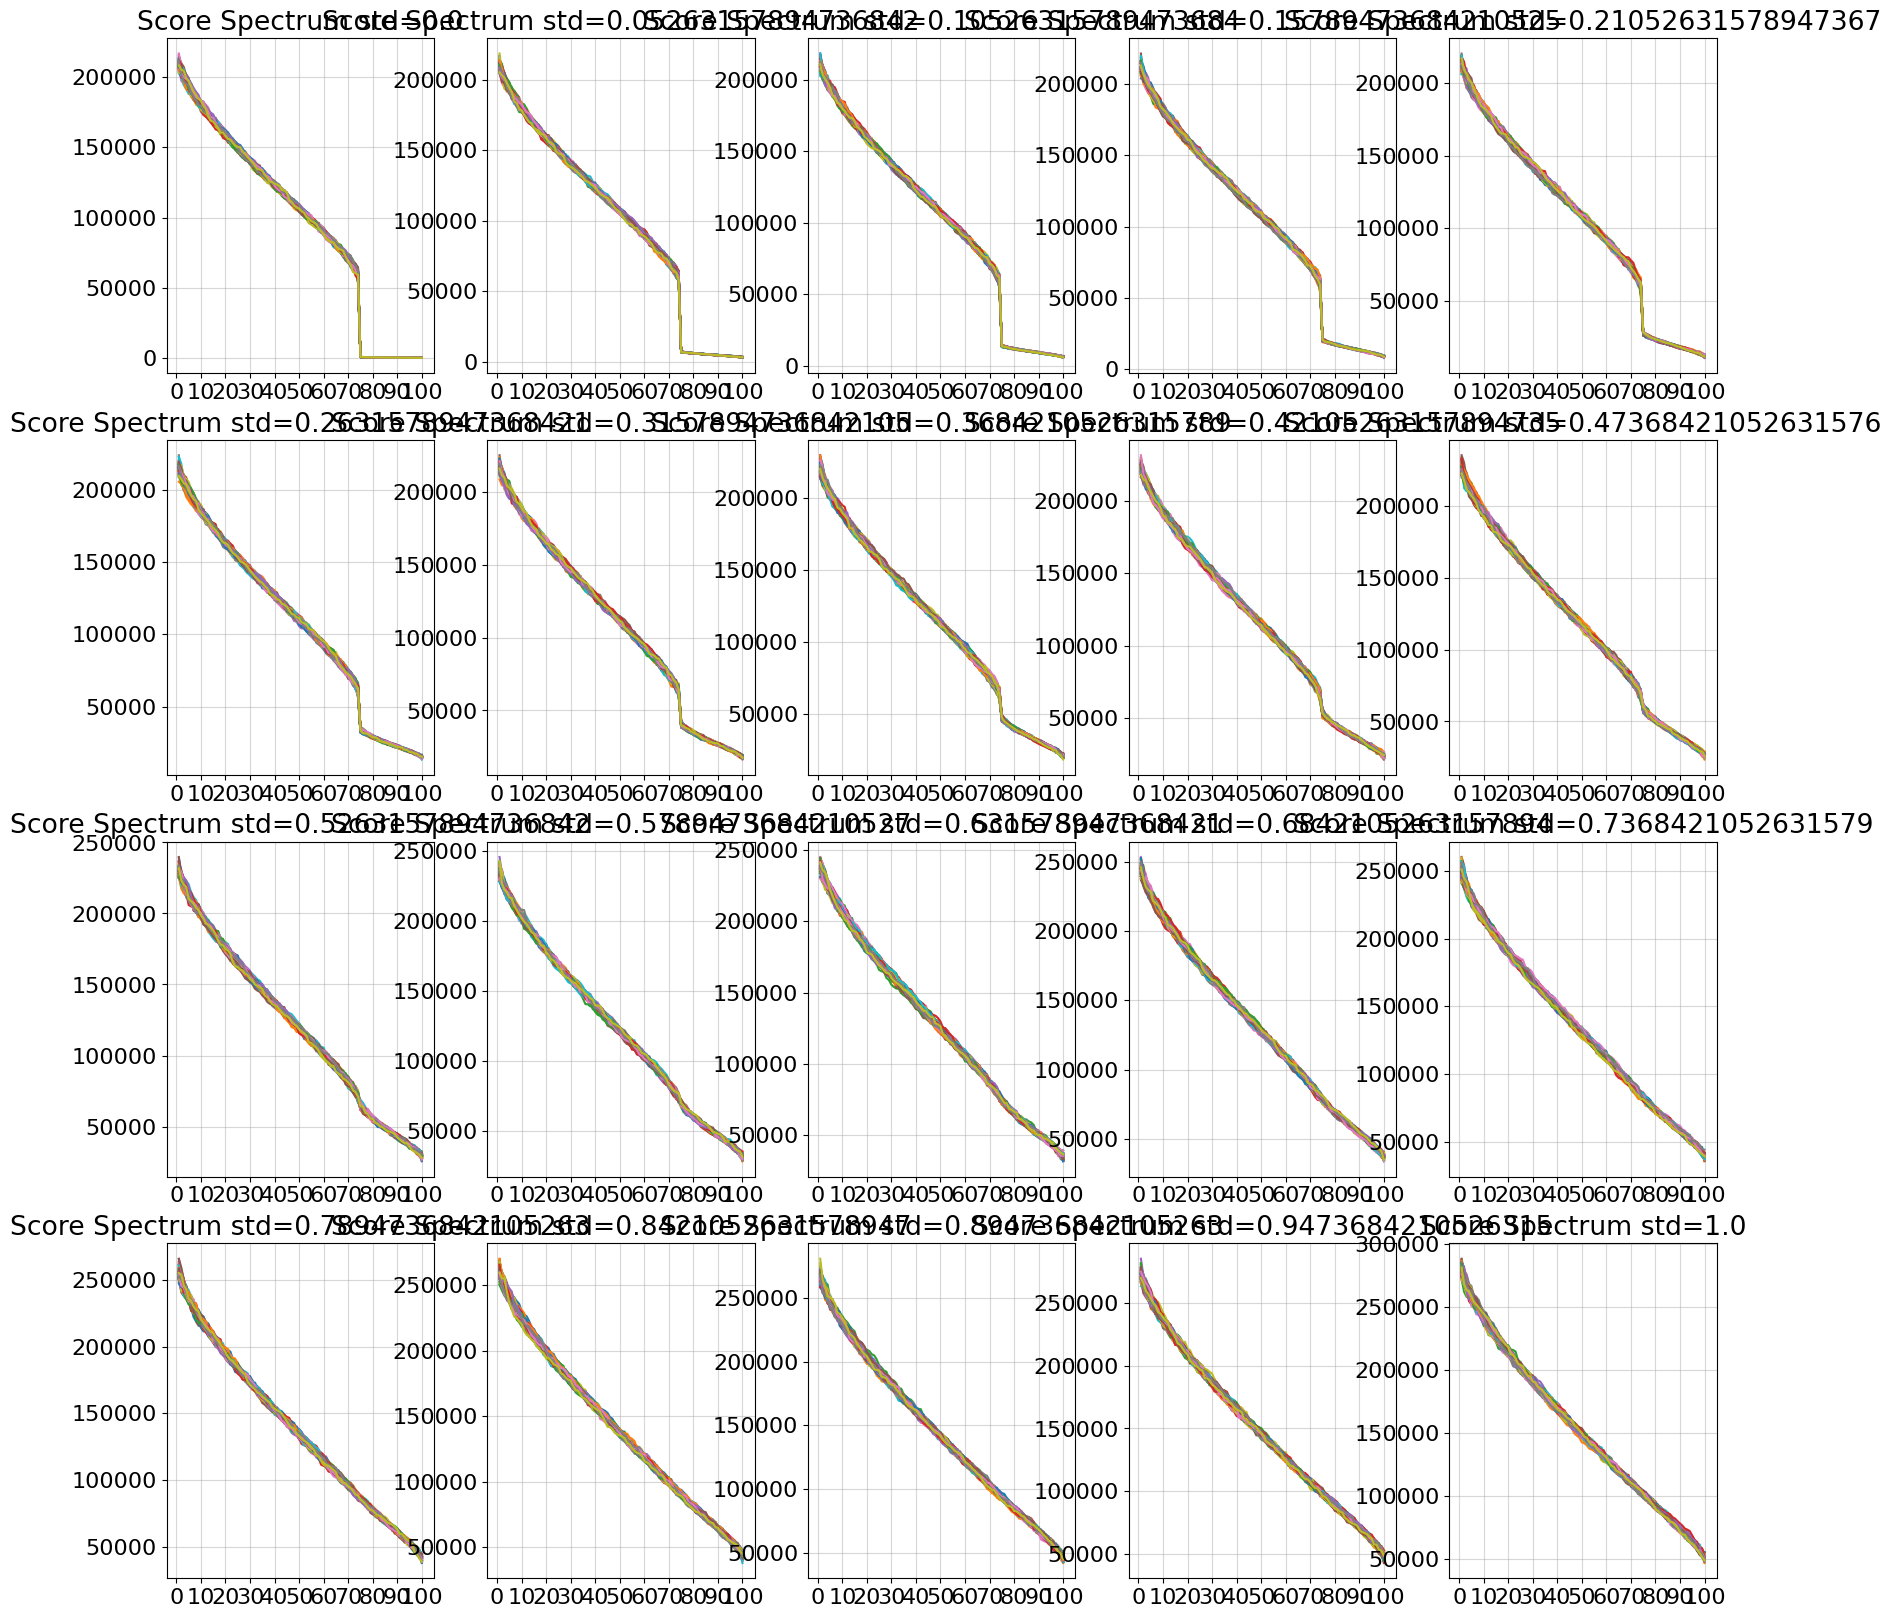

In [20]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(4, 5,figsize=(20,20))
axes = axes.flatten()
#ax.rcParams.update({'font.size': 16})

for i, (std, singular_values) in enumerate(zip(stds, r)):
    sing_vals = singular_values[0]
    axes[i].grid(alpha=0.5)
    axes[i].set_title(f'Score Spectrum std={std}')
    axes[i].set_xticks(np.arange(0, len(sing_vals)+1, 10))
    for sing_vals in singular_values:
        #axes[i].bar(list(range(1, len(sing_vals)+1)),sing_vals)
        axes[i].plot(list(range(1, len(sing_vals)+1)),sing_vals)
    #axes[i].legend()
#plt.xticks(range(0, 100, 5))
#plt.vlines(95, 0, np.max(s), color='r', linestyles='--')
#plt.vlines(70, 0, np.max(s), color='r', linestyles='--')
fig.show()

In [14]:
def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference

In [15]:
dims = []
for i, (std, s) in enumerate(zip(stds, r)):
    norm_factor = s[1]-s[2]
    diff = [(s[i]-s[i+1])/norm_factor for i in range(1, len(s)-1)]
    soft = softmax(diff)
    dims.append(len(soft) - soft.argmax())

In [16]:
dims

[51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 97,
 75,
 89,
 97,
 97,
 93,
 92]

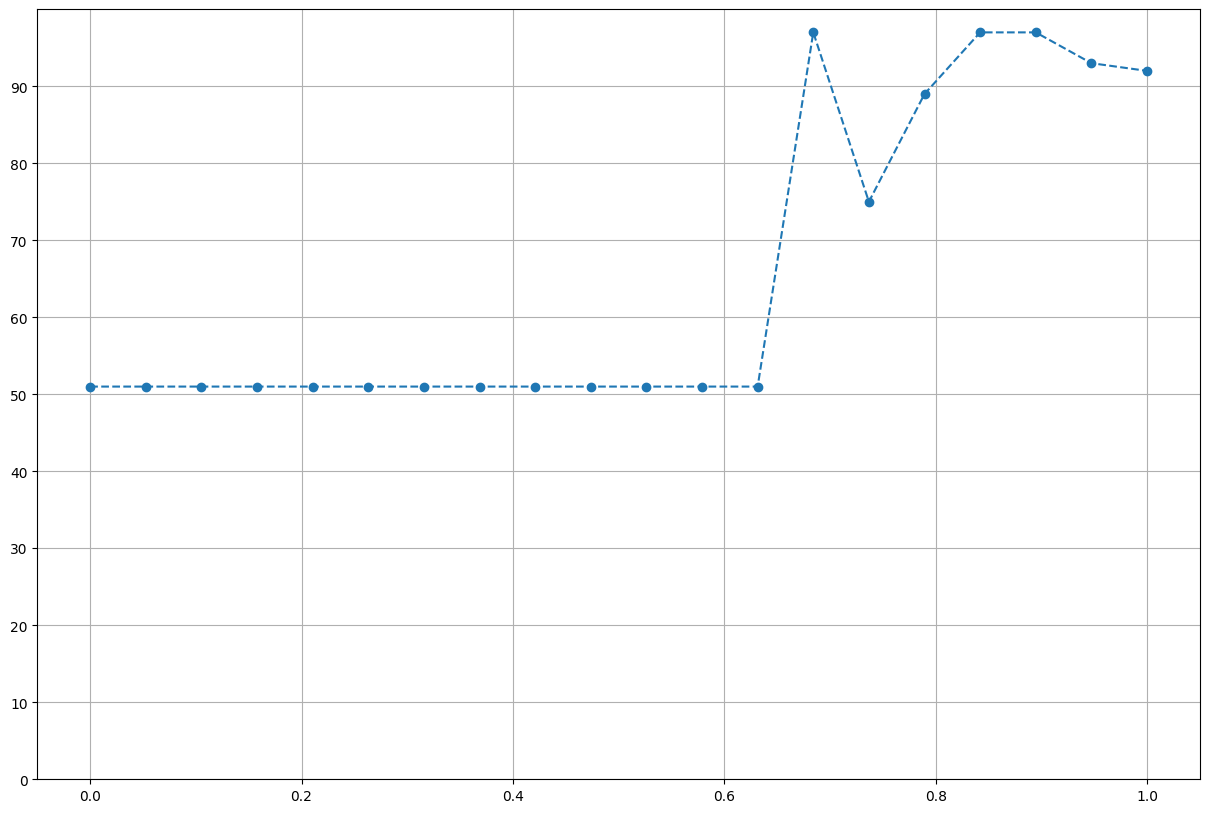

In [19]:
plt.figure(figsize=(15,10))
plt.plot(stds, dims, 'o--')
plt.ylim(0,100)
plt.yticks(range(0,100,10))
plt.grid()